
Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_bbox_loss': 1.0, 'rpn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

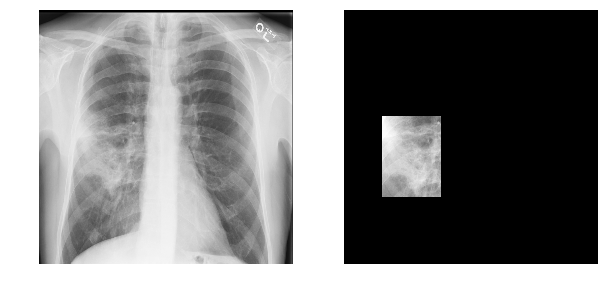

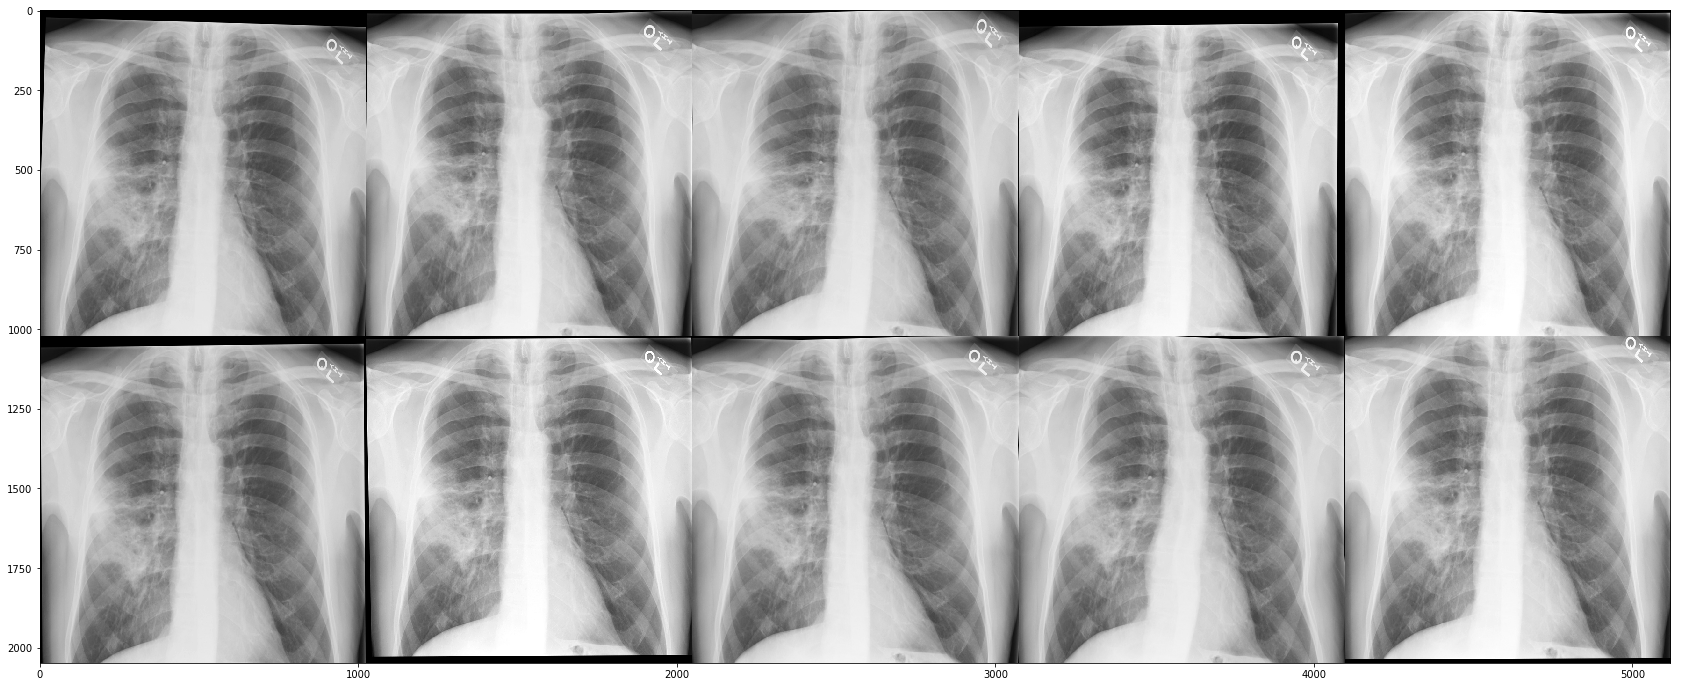

In [11]:

import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob
#from sklearn.model_selection import KFold
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
os.environ['CUDA_VISIBLE_DEVICES']="0"
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.4
set_session(tf.Session(config=config))



#DATA_DIR = '/kaggle/input'
DATA_DIR = '/data/krf/dataset'
# Directory to save logs and trained model
#ROOT_DIR = '/kaggle/working'
ROOT_DIR = '/data/krf/model/rsna'

# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

train_dicom_dir = os.path.join(DATA_DIR, 'stage_1_train_images')
test_dicom_dir = os.path.join(DATA_DIR, 'stage_1_test_images')

COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 



# The following parameters have been selected to reduce running time for demonstration purposes 
# These are not optimal 

class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 3
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.7  ## match target distribution
    DETECTION_NMS_THRESHOLD = 0.1

    STEPS_PER_EPOCH = 200

config = DetectorConfig()
config.display()

class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
        
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

# training dataset
anns = pd.read_csv(os.path.join(DATA_DIR, 'stage_1_train_labels.csv'))
anns.head()


image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)

ds = pydicom.read_file(image_fps[0]) # read dicom image from filepath 
image = ds.pixel_array # get image array

# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024

image_fps_list = list(image_fps)
random.seed(42)
random.shuffle(image_fps_list)
val_size = 1500
image_fps_val = image_fps_list[:val_size]
image_fps_train = image_fps_list[val_size:]

print(len(image_fps_train), len(image_fps_val))
# print(image_fps_val[:6])

# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

# Show annotation(s) for a DICOM image 
test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()


# Load and display random sample and their bounding boxes

class_ids = [0]
while class_ids[0] == 0:  ## look for a mask
    image_id = random.choice(dataset_train.image_ids)
    image_fp = dataset_train.image_reference(image_id)
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

# Image augmentation (light but constant)
augmentation = iaa.Sequential([
    iaa.OneOf([ ## geometric transform
        iaa.Affine(
            scale={"x": (0.98, 1.02), "y": (0.98, 1.04)},
            translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
            rotate=(-2, 2),
            shear=(-1, 1),
        ),
        iaa.PiecewiseAffine(scale=(0.001, 0.025)),
    ]),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ]),
])

# test on the same image as above
imggrid = augmentation.draw_grid(image[:, :, 0], cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid[:, :, 0], cmap='gray')


In [26]:
## select trained model 
model_dir = ROOT_DIR
dir_names = next(os.walk(model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(model_dir))
    
fps = []
# Pick last directory
#for d in dir_names: 
best_epoch = 25 #the last epoch

d = dir_names[-1]    
dir_name = os.path.join(model_dir, d)
# Find the last checkpoint
checkpoints = next(os.walk(dir_name))[2]
#print(checkpoints)
checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
checkpoints = sorted(checkpoints)
if not checkpoints:
    print('No weight files in {}'.format(dir_name))
else:
    print(checkpoints)
    checkpoint = os.path.join(dir_name, checkpoints[best_epoch])
    fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))


class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors


# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
# fig = plt.figure(figsize=(10, 30))

# for i in range(6):

#     image_id = random.choice(dataset.image_ids)
    
#     original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
#         modellib.load_image_gt(dataset_val, inference_config, 
#                                image_id, use_mini_mask=False)
    
#     print(original_image.shape)
#     plt.subplot(6, 2, 2*i + 1)
#     visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
#                                 dataset.class_names,
#                                 colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
#     plt.subplot(6, 2, 2*i + 2)
#     results = model.detect([original_image]) #, verbose=1)
#     r = results[0]
#     visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
#                                 dataset.class_names, r['scores'], 
#                                 colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])







['mask_rcnn_pneumonia_0001.h5', 'mask_rcnn_pneumonia_0002.h5', 'mask_rcnn_pneumonia_0003.h5', 'mask_rcnn_pneumonia_0004.h5', 'mask_rcnn_pneumonia_0005.h5', 'mask_rcnn_pneumonia_0006.h5', 'mask_rcnn_pneumonia_0007.h5', 'mask_rcnn_pneumonia_0008.h5', 'mask_rcnn_pneumonia_0009.h5', 'mask_rcnn_pneumonia_0010.h5', 'mask_rcnn_pneumonia_0011.h5', 'mask_rcnn_pneumonia_0012.h5', 'mask_rcnn_pneumonia_0013.h5', 'mask_rcnn_pneumonia_0014.h5', 'mask_rcnn_pneumonia_0015.h5', 'mask_rcnn_pneumonia_0016.h5', 'mask_rcnn_pneumonia_0017.h5', 'mask_rcnn_pneumonia_0018.h5', 'mask_rcnn_pneumonia_0019.h5', 'mask_rcnn_pneumonia_0020.h5', 'mask_rcnn_pneumonia_0021.h5', 'mask_rcnn_pneumonia_0022.h5', 'mask_rcnn_pneumonia_0023.h5', 'mask_rcnn_pneumonia_0024.h5', 'mask_rcnn_pneumonia_0025.h5', 'mask_rcnn_pneumonia_0026.h5', 'mask_rcnn_pneumonia_0027.h5', 'mask_rcnn_pneumonia_0028.h5', 'mask_rcnn_pneumonia_0029.h5', 'mask_rcnn_pneumonia_0030.h5', 'mask_rcnn_pneumonia_0031.h5', 'mask_rcnn_pneumonia_0032.h5', 'mask_r







  0%|          | 0/1000 [00:00<?, ?it/s]





  0%|          | 1/1000 [00:00<07:49,  2.13it/s]





  0%|          | 2/1000 [00:00<07:25,  2.24it/s]





  0%|          | 3/1000 [00:01<07:10,  2.32it/s]





  0%|          | 4/1000 [00:01<07:19,  2.27it/s]





  0%|          | 5/1000 [00:02<07:09,  2.32it/s]





  1%|          | 6/1000 [00:02<07:16,  2.28it/s]





  1%|          | 7/1000 [00:03<07:15,  2.28it/s]





  1%|          | 8/1000 [00:03<06:59,  2.37it/s]





  1%|          | 9/1000 [00:03<07:08,  2.31it/s]





  1%|          | 10/1000 [00:04<06:47,  2.43it/s]





  1%|          | 11/1000 [00:04<06:49,  2.41it/s]





  1%|          | 12/1000 [00:05<07:02,  2.34it/s]





  1%|▏         | 13/1000 [00:05<07:29,  2.20it/s]





  1%|▏         | 14/1000 [00:06<07:45,  2.12it/s]





  2%|▏         | 15/1000 [00:06<07:28,  2.20it/s]





  2%|▏         | 16/1000 [00:07<07:42,  2.13it/s]





  2%|▏         | 17/1000 [00:07<07:06,  2.30it/s]





  2%|▏         | 18/10

 22%|██▏       | 222/1000 [01:35<05:38,  2.30it/s]





 22%|██▏       | 223/1000 [01:35<06:05,  2.12it/s]





 22%|██▏       | 224/1000 [01:35<05:51,  2.21it/s]





 22%|██▎       | 225/1000 [01:36<05:39,  2.28it/s]





 23%|██▎       | 226/1000 [01:36<05:59,  2.15it/s]





 23%|██▎       | 227/1000 [01:37<05:49,  2.21it/s]





 23%|██▎       | 228/1000 [01:37<05:07,  2.51it/s]





 23%|██▎       | 229/1000 [01:37<05:01,  2.56it/s]





 23%|██▎       | 230/1000 [01:38<05:21,  2.40it/s]





 23%|██▎       | 231/1000 [01:38<05:33,  2.31it/s]





 23%|██▎       | 232/1000 [01:39<05:03,  2.53it/s]





 23%|██▎       | 233/1000 [01:39<05:33,  2.30it/s]





 23%|██▎       | 234/1000 [01:40<05:37,  2.27it/s]





 24%|██▎       | 235/1000 [01:40<05:36,  2.27it/s]





 24%|██▎       | 236/1000 [01:41<06:09,  2.07it/s]





 24%|██▎       | 237/1000 [01:41<06:03,  2.10it/s]





 24%|██▍       | 238/1000 [01:42<05:45,  2.21it/s]





 24%|██▍       | 239/1000 [01:42<05:25,  2.34it/

 44%|████▍     | 442/1000 [03:03<03:51,  2.41it/s]





 44%|████▍     | 443/1000 [03:04<04:02,  2.30it/s]





 44%|████▍     | 444/1000 [03:04<04:06,  2.26it/s]





 44%|████▍     | 445/1000 [03:04<04:03,  2.28it/s]





 45%|████▍     | 446/1000 [03:05<04:21,  2.12it/s]





 45%|████▍     | 447/1000 [03:05<04:01,  2.29it/s]





 45%|████▍     | 448/1000 [03:06<03:57,  2.32it/s]





 45%|████▍     | 449/1000 [03:06<03:56,  2.33it/s]





 45%|████▌     | 450/1000 [03:07<04:01,  2.28it/s]





 45%|████▌     | 451/1000 [03:07<04:15,  2.15it/s]





 45%|████▌     | 452/1000 [03:08<04:16,  2.13it/s]





 45%|████▌     | 453/1000 [03:08<04:15,  2.14it/s]





 45%|████▌     | 454/1000 [03:09<04:18,  2.11it/s]





 46%|████▌     | 455/1000 [03:09<04:12,  2.16it/s]





 46%|████▌     | 456/1000 [03:10<04:25,  2.05it/s]





 46%|████▌     | 457/1000 [03:10<04:15,  2.13it/s]





 46%|████▌     | 458/1000 [03:11<04:47,  1.88it/s]





 46%|████▌     | 459/1000 [03:11<04:01,  2.24it/

 66%|██████▌   | 662/1000 [04:18<01:43,  3.26it/s]





 66%|██████▋   | 663/1000 [04:18<01:47,  3.12it/s]





 66%|██████▋   | 664/1000 [04:19<01:50,  3.05it/s]





 66%|██████▋   | 665/1000 [04:19<01:49,  3.06it/s]





 67%|██████▋   | 666/1000 [04:19<01:42,  3.26it/s]





 67%|██████▋   | 667/1000 [04:19<01:39,  3.36it/s]





 67%|██████▋   | 668/1000 [04:20<01:39,  3.32it/s]





 67%|██████▋   | 669/1000 [04:20<01:39,  3.34it/s]





 67%|██████▋   | 670/1000 [04:20<01:36,  3.41it/s]





 67%|██████▋   | 671/1000 [04:21<01:42,  3.19it/s]





 67%|██████▋   | 672/1000 [04:21<01:40,  3.28it/s]





 67%|██████▋   | 673/1000 [04:21<01:41,  3.21it/s]





 67%|██████▋   | 674/1000 [04:22<01:44,  3.13it/s]





 68%|██████▊   | 675/1000 [04:22<01:38,  3.30it/s]





 68%|██████▊   | 676/1000 [04:22<01:35,  3.41it/s]





 68%|██████▊   | 677/1000 [04:22<01:32,  3.47it/s]





 68%|██████▊   | 678/1000 [04:23<01:39,  3.23it/s]





 68%|██████▊   | 679/1000 [04:23<01:32,  3.46it/

 88%|████████▊ | 882/1000 [05:24<00:39,  2.96it/s]





 88%|████████▊ | 883/1000 [05:24<00:39,  2.99it/s]





 88%|████████▊ | 884/1000 [05:24<00:37,  3.06it/s]





 88%|████████▊ | 885/1000 [05:25<00:35,  3.19it/s]





 89%|████████▊ | 886/1000 [05:25<00:35,  3.20it/s]





 89%|████████▊ | 887/1000 [05:25<00:34,  3.28it/s]





 89%|████████▉ | 888/1000 [05:26<00:35,  3.19it/s]





 89%|████████▉ | 889/1000 [05:26<00:36,  3.08it/s]





 89%|████████▉ | 890/1000 [05:26<00:35,  3.13it/s]





 89%|████████▉ | 891/1000 [05:27<00:36,  3.01it/s]





 89%|████████▉ | 892/1000 [05:27<00:33,  3.27it/s]





 89%|████████▉ | 893/1000 [05:27<00:31,  3.35it/s]





 89%|████████▉ | 894/1000 [05:27<00:31,  3.40it/s]





 90%|████████▉ | 895/1000 [05:28<00:30,  3.41it/s]





 90%|████████▉ | 896/1000 [05:28<00:29,  3.57it/s]





 90%|████████▉ | 897/1000 [05:28<00:30,  3.41it/s]





 90%|████████▉ | 898/1000 [05:29<00:29,  3.46it/s]





 90%|████████▉ | 899/1000 [05:29<00:29,  3.46it/

/data/krf/model/rsna/submission1023_0.95.csv
0e266ced-46fe-4868-8a5a-ef1be71d8f9a
[214 101 309 209]
x 202 y 428 h 216 w 190
[233 297 312 410]
x 594 y 466 h 226 w 158
3022b5a2-88d8-48b8-8f90-55e037f4e86b
[284  99 375 201]
x 198 y 568 h 204 w 182
[306 340 375 428]
x 680 y 612 h 176 w 138
27aa5880-422d-4084-b907-409754c89713
[416 285 486 407]
x 570 y 832 h 244 w 140
[223 313 358 433]
x 626 y 446 h 240 w 270
[245 100 360 214]
x 200 y 490 h 228 w 230
1fbb3006-6ce6-47a5-be74-9ddcaf9b3ef0
[127 273 339 403]
x 546 y 254 h 260 w 424
[210 110 329 196]
x 220 y 420 h 172 w 238
[145  73 227 190]
x 146 y 290 h 234 w 164


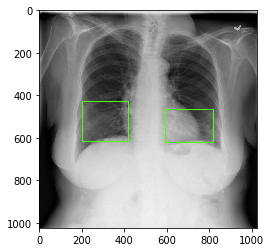

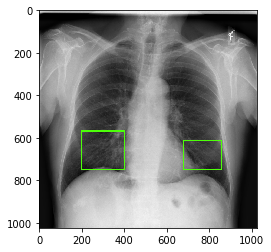

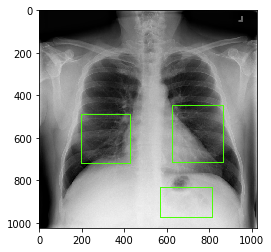

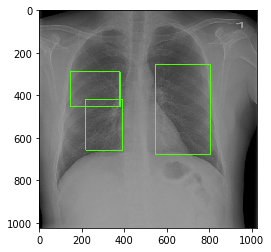

In [44]:
# Get filenames of test dataset DICOM images
test_image_fps = get_dicom_fps(test_dicom_dir)
# Make predictions on test images, write out sample submission
def predict(image_fps, filepath='submission.csv', min_conf=0.95):
    # assume square image
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    #resize_factor = ORIG_SIZE
    labelFile = 'stage_1_test_labels.csv'
    test_labels = pd.read_csv(labelFile)
    
    with open(filepath, 'w') as file:
        file.write("patientId,PredictionString\n")
      
        for image_id in tqdm(image_fps):
            patient_id = os.path.splitext(os.path.basename(image_id))[0]
            out_str = ""
            out_str += patient_id
            out_str += ","
            tmp = test_labels[test_labels['patientId']==patient_id]
            tmp = tmp['Target']==0  
            if tmp.bool() and not tmp.bool():#without classification
                pass
            else:   
                ds = pydicom.read_file(image_id)
                image = ds.pixel_array
                # If grayscale. Convert to RGB for consistency.
                if len(image.shape) != 3 or image.shape[2] != 3:
                    image = np.stack((image,) * 3, -1)
                image, window, scale, padding, crop = utils.resize_image(
                    image,
                    min_dim=config.IMAGE_MIN_DIM,
                    min_scale=config.IMAGE_MIN_SCALE,
                    max_dim=config.IMAGE_MAX_DIM,
                    mode=config.IMAGE_RESIZE_MODE)

                results = model.detect([image])
                r = results[0]
                assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
                if len(r['rois']) == 0:
                    pass
                else:
                    num_instances = len(r['rois'])

                    for i in range(num_instances):
                        if r['scores'][i] > min_conf:
                            out_str += ' '
                            out_str += str(round(r['scores'][i], 2))
                            out_str += ' '

                            # x1, y1, width, height
                            x1 = r['rois'][i][1]
                            y1 = r['rois'][i][0]
                            width = r['rois'][i][3] - x1
                            height = r['rois'][i][2] - y1
                            bboxes_str = "{} {} {} {}".format(x1*resize_factor, y1*resize_factor, \
                                                               width*resize_factor, height*resize_factor)
                            out_str += bboxes_str

            file.write(out_str+"\n")

submission_fp = os.path.join(ROOT_DIR, 'submission1023_0.95.csv')
predict(test_image_fps, filepath=submission_fp,min_conf=0.95)
print(submission_fp)

output = pd.read_csv(submission_fp)
output.head(60)


# show a few test image detection example
def visualize(): 
    image_id = random.choice(test_image_fps)
    ds = pydicom.read_file(image_id)
    
    # original image 
    image = ds.pixel_array
    
    # assume square image 
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    
    # If grayscale. Convert to RGB for consistency.
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1) 
    resized_image, window, scale, padding, crop = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)

    patient_id = os.path.splitext(os.path.basename(image_id))[0]
    print(patient_id)

    results = model.detect([resized_image])
    r = results[0]
    for bbox in r['rois']: 
        print(bbox)
        x1 = int(bbox[1] * resize_factor)
        y1 = int(bbox[0] * resize_factor)
        x2 = int(bbox[3] * resize_factor)
        y2 = int(bbox[2]  * resize_factor)
        cv2.rectangle(image, (x1,y1), (x2,y2), (77, 255, 9), 3, 1)
        width = x2 - x1 
        height = y2 - y1 
        print("x {} y {} h {} w {}".format(x1, y1, width, height))
    plt.figure() 
    plt.imshow(image, cmap=plt.cm.gist_gray)
    plt.savefig(ROOT_DIR+"/"+patient_id+".png")
visualize()
visualize()
visualize()
visualize()


In [13]:
import numpy as np
# helper function to calculate IoU
def iou(box1, box2):
    x11, y11, w1, h1 = box1
    x21, y21, w2, h2 = box2
    #assert w1 * h1 > 0
    #assert w2 * h2 > 0
    x12, y12 = x11 + w1, y11 + h1
    x22, y22 = x21 + w2, y21 + h2

    area1, area2 = w1 * h1, w2 * h2
    xi1, yi1, xi2, yi2 = max([x11, x21]), max([y11, y21]), min([x12, x22]), min([y12, y22])
    
    if xi2 <= xi1 or yi2 <= yi1:
        return 0
    else:
        intersect = (xi2-xi1) * (yi2-yi1)
        union = area1 + area2 - intersect
        return intersect / union
    
# simple test
box1 = [100, 100, 200, 200]
box2 = [100, 100, 300, 200]
print(iou(box1, box2))


0.6666666666666666


In [25]:
def map_iou(boxes_true, boxes_pred, scores, thresholds = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75],min_conf=0.9):
    """
    Mean average precision at differnet intersection over union (IoU) threshold
    
    input:
        boxes_true: Mx4 numpy array of ground true bounding boxes of one image. 
                    bbox format: (x1, y1, w, h)
        boxes_pred: Nx4 numpy array of predicted bounding boxes of one image. 
                    bbox format: (x1, y1, w, h)
        scores:     length N numpy array of scores associated with predicted bboxes
        thresholds: IoU shresholds to evaluate mean average precision on
    output: 
        map: mean average precision of the image
    """
    
    # According to the introduction, images with no ground truth bboxes will not be 
    # included in the map score unless there is a false positive detection (?)
        
    # return None if both are empty, don't count the image in final evaluation (?)
    if len(boxes_true) == 0 and len(boxes_pred) == 0:
        return 0
    
    assert boxes_true.shape[1] == 4 or boxes_pred.shape[1] == 4, "boxes should be 2D arrays with shape[1]=4"
    if len(boxes_pred):
        assert len(scores) == len(boxes_pred), "boxes_pred and scores should be same length"
        # sort boxes_pred by scores in decreasing order
        scores = np.array(scores)
        boxes_pred = boxes_pred[scores>=min_conf]
        scores = scores[scores>=min_conf]
        boxes_pred = boxes_pred[np.argsort(scores)[::-1], :]
        
    if len(boxes_true) == 0 and len(boxes_pred) == 0:
        return 0
    
    map_total = 0
    
    # loop over thresholds
    for t in thresholds:
        matched_bt = set()
        tp, fn = 0, 0
        for i, bt in enumerate(boxes_true):
            matched = False
            for j, bp in enumerate(boxes_pred):
                miou = iou(bt, bp)
                if miou >= t and not matched and j not in matched_bt:
                    matched = True
                    tp += 1 # bt is matched for the first time, count as TP
                    matched_bt.add(j)
            if not matched:
                fn += 1 # bt has no match, count as FN
                
        fp = len(boxes_pred) - len(matched_bt) # FP is the bp that not matched to any bt
        m = tp / (tp + fn + fp)
        map_total += m
    
    return map_total / len(thresholds)
# simple test
boxes_true = np.array([[100, 100, 200, 200]])
boxes_pred = np.array([[100, 100, 300, 200]])
scores = [0.9]

map_iou(boxes_true, boxes_pred, scores)

0.75

In [27]:
# detection on val_data
def evaluate(dataset_eval):
    summ = 0.0
    # assume square image
    
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    #resize_factor = ORIG_SIZE
    for image_id in tqdm(dataset_eval.image_ids):
        original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
                modellib.load_image_gt(dataset_eval, inference_config, 
                                       image_id, use_mini_mask=False)
         
        results = model.detect([original_image]) #, verbose=1)
        r = results[0]
        summ += map_iou(gt_bbox,r['rois'],r['scores'])

    return summ/len(dataset_eval.image_ids)

print(evaluate(dataset_val))

100%|██████████| 1500/1500 [05:19<00:00,  5.99it/s]

0.12035416666666666


In [6]:
#classifier
import glob,pylab,pandas as pd
import pydicom,numpy as np
import random
import json
import time
import copy
import torchvision
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from matplotlib import patches,patheffects

from sklearn.model_selection import train_test_split
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader
from torch.optim import lr_scheduler
from pathlib import Path

PATH = Path("/data/krf/dataset")

class CDataset(Dataset):
    def __init__(self,ds,img_dir,class_df = None,transform=None,ext=None):
        self.ds = ds
        self.img_dir = img_dir
        self.class_df = class_df
        self.ext = ext or '.dcm'
        self.transform = transforms.Compose(transform) if transform else None
    
    def __len__(self):
        return len(self.ds)
    
    def read_dicom_image(self,loc):
        img_arr = pydicom.read_file(loc.as_posix()).pixel_array
        img_arr = img_arr/img_arr.max()
        img_arr = (255*img_arr).clip(0,255).astype(np.uint8)
        img_arr = Image.fromarray(img_arr).convert('RGB')
        return img_arr
    
    def __getitem__(self,i):
        img = self.read_dicom_image(self.ds[i])
        if self.transform:
            img = self.transform(img)
        patientId = self.ds[i].name.split('.')[0]
        #kls = self.class_df[self.class_df['patientId'] == patientId]
        return img,patientId#,kls.iloc[0].Target

use_gpu = torch.cuda.is_available()
print("Use gpu = {}".format(use_gpu))

#dataloaders = {'train':train_dl,'val':test_dl}

device = torch.cuda.set_device(0)


model_ft = torchvision.models.resnet50(pretrained=False)#True)
#修改分类数
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs,2)

criterion = nn.CrossEntropyLoss()
model_ft = model_ft.cuda()

model_ft.load_state_dict(torch.load('resnet50.ckpt'))

Use gpu = True


In [8]:
#classified before detection

def evaluate(dataset_eval):
    summ = 0.0
    count=0
    # assume square image
    
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    #resize_factor = ORIG_SIZE
    for image_id in tqdm(dataset_eval.image_ids):
        original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
                modellib.load_image_gt(dataset_eval, inference_config, 
                                       image_id, use_mini_mask=False)
        ##########CLASSIFY############
        model_ft.eval()
        img_arr = original_image
        img_arr = img_arr/img_arr.max()
        img_arr = (255*img_arr).clip(0,255).astype(np.uint8)
        img_arr = Image.fromarray(img_arr).convert('RGB')
        
        transform = [transforms.Resize(224),transforms.RandomHorizontalFlip(),transforms.ToTensor()]
        transform = transforms.Compose(transform)
        inputs = transform(img_arr)
        inputs = inputs.expand(1,3,224,224)
        inputs = Variable(inputs.cuda(),requires_grad=True)
        outputs = model_ft(inputs)
        #print(outputs)
        _,preds = torch.max(outputs.data,1)
        ##############################
        patient_id = os.path.splitext(os.path.basename(dataset_eval.image_reference(image_id)))[0]
        #print(patient_id)
        
        #print(preds)
        if preds == 0:
            summ += map_iou(gt_bbox,[],[])
        else: 
            count+=1
            results = model.detect([original_image]) #, verbose=1)
            r = results[0]
            summ += map_iou(gt_bbox,r['rois'],r['scores'])
    print(count)
    return summ/len(dataset_eval.image_ids)

print(evaluate(dataset_val))

100%|██████████| 1500/1500 [09:39<00:00,  3.39it/s]

215
0.07050555555555554
0


In [40]:
#segmentation model
train_seg_dir = os.path.join(DATA_DIR, 'stage_1_train_segmentations')
test_seg_dir = os.path.join(DATA_DIR, 'stage_1_test_segmentations')

model_dir = ROOT_DIR
dir_names = next(os.walk(model_dir))[1]
#print(dir_names)
key = 'pneumonia'
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)
print(dir_names)
if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(model_dir))
fps = []
best_epoch = 10
# Pick last directory
#for d in dir_names: 
d = dir_names[-1]    
dir_name = os.path.join(model_dir, d)
# Find the last checkpoint
checkpoints = next(os.walk(dir_name))[2]
#print(checkpoints)
checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
checkpoints = sorted(checkpoints)
if not checkpoints:
    print('No weight files in {}'.format(dir_name))
else:
    print(checkpoints)
    checkpoint = os.path.join(dir_name, checkpoints[best_epoch])
    fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 16
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 5
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.4  ## match target distribution
    DETECTION_NMS_THRESHOLD = 0.1

    STEPS_PER_EPOCH = 1600
config = DetectorConfig()

class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

['pneumonia20181009T1301', 'pneumonia20181009T1439', 'pneumonia20181011T1739', 'pneumonia20181013T1301', 'pneumonia20181016T1658', 'pneumonia20181016T2058', 'pneumonia20181018T1030', 'pneumonia20181019T2207', 'pneumonia20181020T1154', 'pneumonia20181020T1606', 'pneumonia20181020T2103']
['mask_rcnn_pneumonia_0001.h5', 'mask_rcnn_pneumonia_0002.h5', 'mask_rcnn_pneumonia_0003.h5', 'mask_rcnn_pneumonia_0004.h5', 'mask_rcnn_pneumonia_0005.h5', 'mask_rcnn_pneumonia_0006.h5', 'mask_rcnn_pneumonia_0007.h5', 'mask_rcnn_pneumonia_0008.h5', 'mask_rcnn_pneumonia_0009.h5', 'mask_rcnn_pneumonia_0010.h5', 'mask_rcnn_pneumonia_0011.h5', 'mask_rcnn_pneumonia_0012.h5', 'mask_rcnn_pneumonia_0013.h5', 'mask_rcnn_pneumonia_0014.h5', 'mask_rcnn_pneumonia_0015.h5']
Found model /data/krf/model/rsna/pneumonia20181020T2103/mask_rcnn_pneumonia_0011.h5
Loading weights from  /data/krf/model/rsna/pneumonia20181020T2103/mask_rcnn_pneumonia_0011.h5
Re-starting from epoch 11


In [41]:
#segmented before detection
def evaluate(dataset_eval):
    summ = 0.0
    # assume square image  
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    #resize_factor = ORIG_SIZE
    for image_id in tqdm(dataset_eval.image_ids):
        original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
                modellib.load_image_gt(dataset_eval, inference_config, 
                                       image_id, use_mini_mask=False)
        pid = os.path.splitext(os.path.basename(dataset_eval.image_reference(image_id)))[0]
        image = cv2.imread(os.path.join(train_seg_dir,pid+".png"))
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        image, window, scale, padding, crop = utils.resize_image(
            image,
            min_dim=config.IMAGE_MIN_DIM,
            min_scale=config.IMAGE_MIN_SCALE,
            max_dim=config.IMAGE_MAX_DIM,
            mode=config.IMAGE_RESIZE_MODE)
        print(image.shape)
        results = model.detect([image])
        r = results[0] 
        print("pred:",r['rois']*4)
        print("true:",gt_bbox)
        summ += map_iou(gt_bbox,r['rois']*4,r['scores'])

    return summ/len(dataset_eval.image_ids)

print(evaluate(dataset_val))






  0%|          | 0/1500 [00:00<?, ?it/s]

(256, 256, 3)







  0%|          | 1/1500 [00:03<1:18:22,  3.14s/it]




  0%|          | 2/1500 [00:03<56:06,  2.25s/it]  

pred: [[592 196 756 376]
 [624 612 804 776]
 [436 296 644 424]]
true: []
(256, 256, 3)
pred: [[488 652 604 720]
 [444 712 524 808]
 [456 204 596 408]]
true: []







  0%|          | 3/1500 [00:03<40:46,  1.63s/it]

(256, 256, 3)
pred: [[396 544 728 776]
 [508 204 716 396]]
true: [[113 131 195 190]]
(256, 256, 3)







  0%|          | 4/1500 [00:03<29:39,  1.19s/it]

pred: [[532 264 688 424]
 [528 608 688 736]]
true: []
(256, 256, 3)







  0%|          | 5/1500 [00:03<22:41,  1.10it/s]

pred: [[504 216 668 464]
 [592 780 760 936]
 [372 376 548 476]]
true: []
(256, 256, 3)







  0%|          | 6/1500 [00:04<17:32,  1.42it/s]

pred: [[572 228 732 424]
 [608 584 744 704]]
true: []
(256, 256, 3)







  0%|          | 7/1500 [00:04<13:53,  1.79it/s]

pred: [[652 180 984 392]
 [724 624 984 904]
 [452 608 660 736]]
true: [[204  19 256  96]
 [175 164 253 242]]
(256, 256, 3)







  1%|          | 8/1500 [00:04<11:18,  2.20it/s]




  1%|          | 9/1500 [00:04<09:06,  2.73it/s]

pred: [[496 216 696 396]
 [648 692 772 884]
 [376 152 500 268]]
true: []
(256, 256, 3)
pred: [[480 680 764 908]
 [200 296 380 464]
 [484 292 656 464]]
true: []







  1%|          | 10/1500 [00:04<07:39,  3.24it/s]

(256, 256, 3)
pred: [[484 188 664 376]
 [536 600 696 764]
 [300 632 504 728]]
true: []







  1%|          | 11/1500 [00:05<06:57,  3.56it/s]

(256, 256, 3)
pred: [[512 244 696 412]
 [496 604 684 728]]
true: []







  1%|          | 12/1500 [00:05<06:30,  3.81it/s]

(256, 256, 3)
pred: [[128 672 336 832]
 [688 268 836 460]
 [608 636 808 836]]
true: []
(256, 256, 3)







  1%|          | 13/1500 [00:05<06:03,  4.10it/s]

pred: [[516 140 668 384]
 [488 596 664 788]
 [536 760 688 936]]
true: []
(256, 256, 3)







  1%|          | 14/1500 [00:05<05:46,  4.29it/s]




  1%|          | 15/1500 [00:05<05:25,  4.56it/s]

pred: [[484 668 664 792]
 [536 800 644 892]
 [520 268 688 424]]
true: []
(256, 256, 3)
pred: [[496 176 776 400]
 [464 612 784 864]
 [692 760 780 852]]
true: []







  1%|          | 16/1500 [00:06<05:20,  4.63it/s]

(256, 256, 3)
pred: [[504 204 660 372]
 [504 604 692 820]]
true: []







  1%|          | 17/1500 [00:06<05:24,  4.57it/s]

(256, 256, 3)
pred: [[212 228 660 460]
 [184 580 676 864]]
true: [[ 46  69 202 119]
 [ 52 149 194 212]]







  1%|          | 18/1500 [00:06<05:28,  4.52it/s]

(256, 256, 3)
pred: [[196 204 644 484]
 [296 640 624 888]]
true: [[ 61 159 148 204]
 [ 40  62 131 125]]







  1%|▏         | 19/1500 [00:06<05:07,  4.82it/s]

(256, 256, 3)
pred: [[596 100 784 308]
 [608 556 908 768]]
true: []
(256, 256, 3)







  1%|▏         | 20/1500 [00:07<05:19,  4.63it/s]






pred: [[304 344 652 604]
 [436 732 720 968]
 [180 136 580 336]]
true: [[128 178 192 232]
 [ 58 111 149 152]]
(256, 256, 3)
pred: [[420 608 588 732]
 [516 236 756 424]]
true: []


  1%|▏         | 21/1500 [00:07<05:10,  4.76it/s]




  1%|▏         | 22/1500 [00:07<05:18,  4.64it/s]

(256, 256, 3)
pred: [[440 556 720 772]
 [544 180 692 344]
 [264 284 496 416]]
true: []







  2%|▏         | 23/1500 [00:07<05:38,  4.37it/s]

(256, 256, 3)
pred: [[612 204 844 404]
 [604 588 872 816]
 [104 268 340 480]]
true: []







  2%|▏         | 24/1500 [00:07<05:35,  4.40it/s]

(256, 256, 3)
pred: [[664 584 796 792]
 [672 220 832 404]]
true: []
(256, 256, 3)







  2%|▏         | 25/1500 [00:08<05:14,  4.69it/s]




  2%|▏         | 26/1500 [00:08<04:50,  5.07it/s]

pred: [[476 228 688 508]
 [576 712 716 868]]
true: []
(256, 256, 3)
pred: [[440 560 788 760]
 [384 220 728 408]]
true: []







  2%|▏         | 27/1500 [00:08<04:36,  5.33it/s]

(256, 256, 3)
pred: [[516 604 648 752]
 [464 348 600 444]
 [360 340 496 468]]
true: []







  2%|▏         | 28/1500 [00:08<04:41,  5.23it/s]

(256, 256, 3)
pred: [[472 284 624 452]
 [376 372 484 448]
 [448 740 520 832]]
true: []
(256, 256, 3)







  2%|▏         | 29/1500 [00:08<05:01,  4.88it/s]

pred: [[516 228 772 408]
 [648 596 820 776]
 [392 152 556 272]]
true: []
(256, 256, 3)







  2%|▏         | 30/1500 [00:09<05:28,  4.48it/s]

pred: [[212 272 364 420]
 [336 616 488 720]]
true: []
(256, 256, 3)







  2%|▏         | 31/1500 [00:09<05:27,  4.49it/s]

pred: [[172 616 808 892]
 [596 276 800 472]]
true: []
(256, 256, 3)







  2%|▏         | 32/1500 [00:09<05:23,  4.53it/s]

pred: [[504 224 700 440]
 [252 596 740 868]]
true: []
(256, 256, 3)







  2%|▏         | 33/1500 [00:09<05:29,  4.46it/s]

pred: [[620 204 924 396]
 [676 616 868 796]
 [208 292 388 456]]
true: []
(256, 256, 3)







  2%|▏         | 34/1500 [00:10<05:28,  4.46it/s]

pred: [[480 244 628 436]
 [308 632 492 720]]
true: []
(256, 256, 3)







  2%|▏         | 35/1500 [00:10<05:37,  4.34it/s]

pred: [[364 600 664 868]
 [344 296 708 504]
 [668 176 780 328]]
true: []
(256, 256, 3)







  2%|▏         | 36/1500 [00:10<05:49,  4.19it/s]

pred: [[464 172 612 388]
 [620 720 740 880]
 [408 604 580 756]]
true: []
(256, 256, 3)







  2%|▏         | 37/1500 [00:10<05:39,  4.31it/s]

pred: [[524 152 720 404]
 [528 596 728 784]
 [416 576 572 712]]
true: []
(256, 256, 3)







  3%|▎         | 38/1500 [00:10<05:28,  4.45it/s]

pred: [[572 228 716 436]
 [600 636 760 792]
 [500 336 600 448]]
true: []
(256, 256, 3)







  3%|▎         | 39/1500 [00:11<05:32,  4.39it/s]

pred: [[336 568 820 808]
 [312 232 772 448]]
true: [[ 64  64 166 117]
 [ 70 139 191 200]]
(256, 256, 3)







  3%|▎         | 40/1500 [00:11<05:33,  4.38it/s]

pred: [[600 216 820 392]
 [536 624 828 832]
 [200 352 400 496]]
true: []
(256, 256, 3)







  3%|▎         | 41/1500 [00:11<05:38,  4.32it/s]




  3%|▎         | 42/1500 [00:11<05:16,  4.60it/s]

pred: [[584 180 796 392]
 [432 624 628 752]
 [520 712 668 856]]
true: []
(256, 256, 3)
pred: [[484 200 672 384]
 [500 572 716 804]
 [372 572 544 708]]
true: []







  3%|▎         | 43/1500 [00:12<04:59,  4.87it/s]

(256, 256, 3)
pred: [[644 740 764 852]
 [616 160 772 344]
 [228 596 320 756]]
true: []
(256, 256, 3)







  3%|▎         | 44/1500 [00:12<04:48,  5.04it/s]

pred: [[272 548 784 816]
 [480 136 720 344]
 [236 216 560 400]]
true: [[ 55  61  93  88]
 [146  35 174  82]
 [ 93 147 181 201]]
(256, 256, 3)







  3%|▎         | 45/1500 [00:12<04:57,  4.88it/s]

pred: [[556 220 744 424]
 [536 648 756 892]
 [372 324 560 464]]
true: []
(256, 256, 3)







  3%|▎         | 46/1500 [00:12<05:09,  4.69it/s]




  3%|▎         | 47/1500 [00:12<04:58,  4.87it/s]

pred: [[368 164 860 408]
 [644 584 924 828]]
true: []
(256, 256, 3)
pred: [[604 276 804 432]
 [440 348 608 456]
 [368 616 572 708]]
true: []







  3%|▎         | 48/1500 [00:13<05:08,  4.71it/s]

(256, 256, 3)
pred: [[252 628 864 892]
 [264 300 760 520]]
true: []


(256, 256, 3)
pred: [[516 160 648 356]
 [456 588 632 808]
 [432 300 588 396]]
true: []


  3%|▎         | 49/1500 [00:13<05:48,  4.17it/s]




  3%|▎         | 50/1500 [00:13<05:53,  4.10it/s]

(256, 256, 3)
pred: [[584 592 780 788]
 [576 216 784 424]
 [364 576 560 672]]
true: []







  3%|▎         | 51/1500 [00:13<05:45,  4.19it/s]

(256, 256, 3)
pred: [[500 556 788 776]
 [556 180 736 380]]
true: [[131 129 211 204]
 [142  30 203 106]]
(256, 256, 3)







  3%|▎         | 52/1500 [00:14<05:13,  4.62it/s]




  4%|▎         | 53/1500 [00:14<04:59,  4.84it/s]

pred: [[512 580 716 824]
 [528 200 692 356]
 [216 620 336 716]]
true: []
(256, 256, 3)
pred: [[216 584 544 780]
 [304 192 704 460]
 [656 192 928 416]]
true: []







  4%|▎         | 54/1500 [00:14<04:52,  4.95it/s]

(256, 256, 3)
pred: [[376 176 880 464]
 [368 580 876 812]]
true: [[ 81 146 254 238]
 [ 85  35 251 123]]
(256, 256, 3)







  4%|▎         | 55/1500 [00:14<04:33,  5.29it/s]




  4%|▎         | 56/1500 [00:14<04:24,  5.46it/s]

pred: [[248 312 428 464]
 [688 244 904 400]
 [484 636 784 760]]
true: []
(256, 256, 3)
pred: [[552 164 716 364]
 [668 580 824 792]
 [292 580 452 696]]
true: []







  4%|▍         | 57/1500 [00:14<04:41,  5.13it/s]

(256, 256, 3)
pred: [[288 592 800 916]
 [216 320 452 496]
 [596 232 760 448]]
true: [[ 74 162 177 232]]







  4%|▍         | 58/1500 [00:15<04:40,  5.13it/s]

(256, 256, 3)
pred: [[428 192 544 404]
 [420 604 688 820]
 [176 620 468 804]]
true: [[102  50 133  99]]
(256, 256, 3)







  4%|▍         | 59/1500 [00:15<04:38,  5.17it/s]




  4%|▍         | 60/1500 [00:15<04:33,  5.27it/s]

pred: [[468 224 600 440]
 [488 740 608 856]
 [312 628 496 720]]
true: []
(256, 256, 3)
pred: [[528 148 684 396]
 [540 692 688 876]]
true: []







  4%|▍         | 61/1500 [00:15<04:27,  5.38it/s]

(256, 256, 3)
pred: [[568 232 720 436]
 [320 628 552 744]
 [588 628 760 792]]
true: []
(256, 256, 3)







  4%|▍         | 62/1500 [00:15<04:29,  5.34it/s]




  4%|▍         | 63/1500 [00:16<04:22,  5.47it/s]

pred: [[320 172 720 404]
 [408 600 788 804]]
true: [[ 23  42 188 113]
 [ 83 149 223 210]]
(256, 256, 3)
pred: [[468 604 644 744]
 [336 596 496 724]
 [548 248 648 436]]
true: []







  4%|▍         | 64/1500 [00:16<04:16,  5.60it/s]

(256, 256, 3)
pred: [[608 156 780 384]
 [216 132 420 324]
 [716 556 888 736]]
true: []
(256, 256, 3)







  4%|▍         | 65/1500 [00:16<04:40,  5.11it/s]




  4%|▍         | 66/1500 [00:16<04:39,  5.14it/s]

pred: [[292 128 668 408]
 [328 608 616 860]]
true: []
(256, 256, 3)
pred: [[264 248 624 464]
 [588 596 796 836]
 [556 216 712 376]]
true: []







  4%|▍         | 67/1500 [00:16<04:38,  5.14it/s]

(256, 256, 3)
pred: [[552 316 648 416]
 [472 716 672 920]
 [396 636 584 736]]
true: []
(256, 256, 3)







  5%|▍         | 68/1500 [00:16<04:21,  5.48it/s]




  5%|▍         | 69/1500 [00:17<04:10,  5.72it/s]

pred: [[428 740 508 836]
 [512 208 684 472]
 [368 324 516 456]]
true: [[129  49 179 124]]
(256, 256, 3)
pred: [[372 244 496 408]
 [388 688 516 788]
 [380 808 468 888]]
true: []







  5%|▍         | 70/1500 [00:17<04:09,  5.74it/s]

(256, 256, 3)
pred: [[676 624 856 788]
 [644 256 852 412]
 [512 324 676 420]]
true: []
(256, 256, 3)







  5%|▍         | 71/1500 [00:17<04:06,  5.79it/s]




  5%|▍         | 72/1500 [00:17<04:04,  5.85it/s]

pred: [[492 244 696 408]
 [600 584 736 720]
 [464 580 620 720]]
true: []
(256, 256, 3)
pred: [[304 600 432 716]
 [420 596 584 756]
 [464 196 576 392]]
true: []







  5%|▍         | 73/1500 [00:17<04:20,  5.49it/s]

(256, 256, 3)
pred: [[532 244 780 452]
 [428 624 580 732]]
true: []
(256, 256, 3)







  5%|▍         | 74/1500 [00:18<04:10,  5.69it/s]




  5%|▌         | 75/1500 [00:18<04:15,  5.57it/s]

pred: [[312 664 452 812]
 [188 612 324 744]
 [648 752 736 852]]
true: [[ 78 153 120 202]]
(256, 256, 3)
pred: [[504 296 660 472]
 [188 372 328 512]
 [548 772 652 904]]
true: []







  5%|▌         | 76/1500 [00:18<04:19,  5.49it/s]

(256, 256, 3)
pred: [[336 596 472 692]
 [368 288 576 424]
 [528 672 688 848]]
true: []
(256, 256, 3)







  5%|▌         | 77/1500 [00:18<04:16,  5.54it/s]




  5%|▌         | 78/1500 [00:18<04:17,  5.53it/s]

pred: [[560 676 808 888]
 [656 176 868 396]]
true: [[171  47 209  94]]
(256, 256, 3)
pred: [[592 592 804 820]
 [588 196 772 352]]
true: []







  5%|▌         | 79/1500 [00:18<04:23,  5.39it/s]

(256, 256, 3)
pred: [[356 592 748 824]
 [312 244 712 476]]
true: []







  5%|▌         | 80/1500 [00:19<04:22,  5.41it/s]

(256, 256, 3)
pred: [[492 604 656 768]
 [496 216 644 400]
 [188 260 428 452]]
true: [[140  65 164  94]]
(256, 256, 3)







  5%|▌         | 81/1500 [00:19<04:14,  5.58it/s]

pred: [[460 208 636 364]
 [556 584 724 824]
 [464 604 600 716]]
true: []
(256, 256, 3)
pred:






  5%|▌         | 82/1500 [00:19<04:24,  5.36it/s]






 [[500 176 692 364]
 [592 532 764 716]
 [516 588 632 696]]
true: []
(256, 256, 3)
pred: [[512 172 884 412]
 [588 616 900 896]
 [128 568 304 748]]
true: []


  6%|▌         | 83/1500 [00:19<04:29,  5.26it/s]




  6%|▌         | 84/1500 [00:19<04:40,  5.05it/s]

(256, 256, 3)
pred: [[368 552 784 772]
 [560 228 784 400]]
true: []







  6%|▌         | 85/1500 [00:20<04:36,  5.13it/s]

(256, 256, 3)
pred: [[332 252 440 408]
 [464 628 624 784]
 [432 208 584 396]]
true: [[ 82  65 115 103]]
(256, 256, 3)







  6%|▌         | 86/1500 [00:20<04:32,  5.19it/s]




  6%|▌         | 87/1500 [00:20<04:33,  5.16it/s]

pred: [[508 236 664 404]
 [480 580 708 820]]
true: []
(256, 256, 3)
pred: [[344 576 728 760]
 [464 304 668 448]]
true: [[ 61 135 200 204]
 [ 65  61 192 127]]







  6%|▌         | 88/1500 [00:20<04:12,  5.59it/s]

(256, 256, 3)
pred: [[540 636 688 804]
 [468 276 616 432]]
true: []
(256, 256, 3)







  6%|▌         | 89/1500 [00:20<04:15,  5.52it/s]




  6%|▌         | 90/1500 [00:21<04:11,  5.61it/s]

pred: [[596 140 820 352]
 [596 580 792 808]]
true: []
(256, 256, 3)
pred: [[524 212 652 396]
 [516 584 636 672]
 [508 668 592 780]]
true: []







  6%|▌         | 91/1500 [00:21<04:24,  5.32it/s]

(256, 256, 3)
pred: [[112 576 540 784]
 [584 564 852 808]
 [304 120 816 376]]
true: []







  6%|▌         | 92/1500 [00:21<05:02,  4.66it/s]

(256, 256, 3)
pred: [[364 244 772 484]
 [564 588 828 780]]
true: []







  6%|▌         | 93/1500 [00:21<04:55,  4.76it/s]

(256, 256, 3)
pred: [[488 244 652 408]
 [496 628 652 712]]
true: []
(256, 256, 3)







  6%|▋         | 94/1500 [00:21<04:30,  5.20it/s]




  6%|▋         | 95/1500 [00:22<04:32,  5.15it/s]

pred: [[220 360 304 456]
 [440 312 552 440]
 [556 672 656 756]]
true: []
(256, 256, 3)
pred: [[460 288 668 440]
 [472 604 680 756]]
true: []







  6%|▋         | 96/1500 [00:22<05:01,  4.66it/s]

(256, 256, 3)
pred: [[348 116 596 340]
 [ 88 572 412 756]
 [448 564 680 824]]
true: []







  6%|▋         | 97/1500 [00:22<05:13,  4.48it/s]

(256, 256, 3)
pred: [[188 560 320 696]
 [544 248 664 388]
 [556 560 748 752]]
true: []







  7%|▋         | 98/1500 [00:22<05:17,  4.41it/s]

(256, 256, 3)
pred: [[560 188 732 360]
 [556 588 764 800]
 [512 328 680 420]]
true: []







  7%|▋         | 99/1500 [00:22<05:03,  4.61it/s]

(256, 256, 3)
pred: [[476 544 664 772]
 [484 204 600 384]]
true: []
(256, 256, 3)







  7%|▋         | 100/1500 [00:23<04:43,  4.94it/s]




  7%|▋         | 101/1500 [00:23<04:26,  5.24it/s]

pred: [[632 204 764 420]
 [620 636 824 896]
 [476 336 668 444]]
true: []
(256, 256, 3)
pred: [[396 304 672 528]
 [404 648 732 888]
 [348  76 752 252]]
true: []







  7%|▋         | 102/1500 [00:23<04:14,  5.49it/s]

(256, 256, 3)
pred: [[412 272 588 420]
 [480 588 652 820]
 [236 368 448 460]]
true: []
(256, 256, 3)







  7%|▋         | 103/1500 [00:23<04:12,  5.54it/s]






pred: [[536 184 692 424]
 [480 692 744 932]]
true: []
(256, 256, 3)
pred: [[576 240 760 420]
 [512 616 800 864]
 [380 228 524 380]]
true: [[ 74  61 186 120]]


  7%|▋         | 104/1500 [00:23<04:21,  5.35it/s]




  7%|▋         | 105/1500 [00:24<04:56,  4.71it/s]

(256, 256, 3)
pred: [[480 196 676 408]
 [244 352 432 456]
 [480 628 676 784]]
true: []







  7%|▋         | 106/1500 [00:24<05:22,  4.32it/s]

(256, 256, 3)
pred: [[376 156 660 392]
 [288 548 676 792]]
true: [[ 47  39 159  98]
 [ 42 136 184 207]]







  7%|▋         | 107/1500 [00:24<05:32,  4.18it/s]

(256, 256, 3)
pred: [[244 140 660 396]
 [376 544 652 768]]
true: []







  7%|▋         | 108/1500 [00:24<05:31,  4.20it/s]

(256, 256, 3)
pred: [[560 100 800 372]
 [600 596 768 804]
 [456 264 640 404]]
true: []







  7%|▋         | 109/1500 [00:25<05:41,  4.07it/s]

(256, 256, 3)
pred: [[268 520 732 732]
 [268 176 708 408]]
true: [[ 47  36 174  96]
 [ 49 130 185 190]]







  7%|▋         | 110/1500 [00:25<06:07,  3.79it/s]

(256, 256, 3)
pred: [[288 428 676 704]
 [252 128 668 352]]
true: [[ 71 123 157 190]
 [125  28 165  83]]







  7%|▋         | 111/1500 [00:25<06:26,  3.59it/s]

(256, 256, 3)
pred: [[488 224 680 416]
 [472 656 568 792]
 [452 324 524 404]]
true: []







  7%|▋         | 112/1500 [00:25<05:52,  3.94it/s]

(256, 256, 3)
pred: [[484 272 700 436]
 [520 640 760 848]
 [220 632 368 792]]
true: []







  8%|▊         | 113/1500 [00:26<05:46,  4.00it/s]

(256, 256, 3)
pred: [[412 576 736 824]
 [444 280 656 424]
 [140 312 292 452]]
true: []







  8%|▊         | 114/1500 [00:26<05:35,  4.13it/s]

(256, 256, 3)
pred: [[504 272 668 432]
 [572 608 700 748]
 [468 388 568 464]]
true: []







  8%|▊         | 115/1500 [00:26<05:22,  4.29it/s]

(256, 256, 3)
pred: [[492 368 664 492]
 [348 432 536 528]
 [540 660 676 772]]
true: []
(256, 256, 3)







  8%|▊         | 116/1500 [00:26<05:03,  4.56it/s]




  8%|▊         | 117/1500 [00:27<04:48,  4.80it/s]

pred: [[544 660 768 888]
 [556 252 728 476]
 [412 664 564 804]]
true: []
(256, 256, 3)
pred: [[620 596 892 808]
 [608 168 844 384]
 [308 552 468 672]]
true: []







  8%|▊         | 118/1500 [00:27<04:56,  4.66it/s]

(256, 256, 3)
pred: [[232 572 704 816]
 [204 196 664 432]]
true: []







  8%|▊         | 119/1500 [00:27<05:06,  4.51it/s]

(256, 256, 3)
pred: [[516 572 708 804]
 [240 108 392 224]]
true: []
(256, 256, 3)







  8%|▊         | 120/1500 [00:27<05:05,  4.52it/s]

pred: [[400 128 588 388]
 [200 544 572 784]]
true: []
(256, 256, 3)







  8%|▊         | 121/1500 [00:27<05:07,  4.49it/s]

pred: [[460 632 708 880]
 [484 200 692 404]
 [184 324 356 472]]
true: []
(256, 256, 3)







  8%|▊         | 122/1500 [00:28<05:11,  4.43it/s]

pred: [[392 752 680 948]
 [676 400 816 568]
 [568 428 696 580]]
true: [[102 198 166 238]
 [143  96 203 138]]
(256, 256, 3)







  8%|▊         | 123/1500 [00:28<05:27,  4.21it/s]

pred: [[272 556 820 852]
 [324 256 500 392]
 [548 152 760 364]]
true: [[ 57 151 113 190]
 [142 158 186 207]
 [ 60  53 119  95]
 [153  42 182  82]]
(256, 256, 3)







  8%|▊         | 124/1500 [00:28<05:15,  4.36it/s]




  8%|▊         | 125/1500 [00:28<04:44,  4.84it/s]

pred: [[408 176 628 408]
 [364 620 532 732]]
true: []
(256, 256, 3)
pred: [[456 224 656 424]
 [504 580 700 700]]
true: []







  8%|▊         | 126/1500 [00:28<04:25,  5.18it/s]

(256, 256, 3)
pred: [[480 580 688 808]
 [500 216 672 372]
 [368 612 504 724]]
true: [[126 163 163 183]]
(256, 256, 3)







  8%|▊         | 127/1500 [00:29<04:24,  5.19it/s]




  9%|▊         | 128/1500 [00:29<04:25,  5.17it/s]

pred: [[264 608 672 812]
 [284 340 604 512]
 [220 212 432 392]]
true: []
(256, 256, 3)
pred: [[480 532 780 756]
 [492 180 748 404]]
true: [[108 133 234 199]
 [108  41 206 101]]







  9%|▊         | 129/1500 [00:29<04:35,  4.98it/s]

(256, 256, 3)
pred: [[376 552 924 836]
 [716 152 932 368]
 [416 232 784 412]]
true: [[ 91 148 228 208]
 [ 84  36 231 104]]







  9%|▊         | 130/1500 [00:29<04:43,  4.83it/s]

(256, 256, 3)
pred: [[508 216 680 404]
 [528 616 692 780]]
true: []
(256, 256, 3)







  9%|▊         | 131/1500 [00:29<04:26,  5.13it/s]




  9%|▉         | 132/1500 [00:30<04:12,  5.41it/s]

pred: [[368 544 692 764]
 [456 172 652 340]
 [204 284 368 412]]
true: []
(256, 256, 3)
pred: [[408 216 620 408]
 [220 584 336 684]
 [544 660 692 832]]
true: []







  9%|▉         | 133/1500 [00:30<04:23,  5.18it/s]

(256, 256, 3)
pred: [[164 152 680 468]
 [244 584 696 824]]
true: [[ 64  54 158 110]
 [ 71 136 176 203]]







  9%|▉         | 134/1500 [00:30<04:29,  5.06it/s]

(256, 256, 3)
pred: [[600 212 804 436]
 [580 636 832 864]
 [156 620 348 736]]
true: []
(256, 256, 3)







  9%|▉         | 135/1500 [00:30<04:37,  4.91it/s]




  9%|▉         | 136/1500 [00:30<04:20,  5.23it/s]

pred: [[480 624 692 948]
 [520 196 668 372]
 [432 340 636 464]]
true: []
(256, 256, 3)
pred: [[476 200 652 372]
 [548 588 656 672]]
true: []







  9%|▉         | 137/1500 [00:31<04:05,  5.56it/s]

(256, 256, 3)
pred: [[656 200 800 400]
 [664 604 808 756]
 [684 732 824 856]]
true: []
(256, 256, 3)







  9%|▉         | 138/1500 [00:31<04:13,  5.38it/s]

pred: [[528 276 772 408]
 [588 580 748 740]
 [340 624 472 716]]
true: []
(256, 256, 3)







  9%|▉         | 139/1500 [00:31<04:24,  5.14it/s]

pred: [[472 200 592 400]
 [408 612 520 748]
 [388 344 528 424]]
true: []
(256, 256, 3)







  9%|▉         | 140/1500 [00:31<04:39,  4.87it/s]

pred: [[364 228 652 420]
 [380 608 628 820]]
true: []
(256, 256, 3)







  9%|▉         | 141/1500 [00:31<05:00,  4.52it/s]

pred: [[496 544 816 788]
 [516 180 816 420]]
true: []
(256, 256, 3)







  9%|▉         | 142/1500 [00:32<05:21,  4.22it/s]

pred: [[532 112 752 372]
 [376 584 652 864]
 [204 136 508 376]]
true: []
(256, 256, 3)







 10%|▉         | 143/1500 [00:32<05:23,  4.20it/s]

pred: [[512 240 676 432]
 [588 628 752 800]
 [292 352 528 476]]
true: []
(256, 256, 3)







 10%|▉         | 144/1500 [00:32<05:16,  4.28it/s]

pred: [[508 232 620 384]
 [348 628 536 716]
 [588 664 724 896]]
true: []
(256, 256, 3)







 10%|▉         | 145/1500 [00:32<05:18,  4.25it/s]

pred: [[392 244 496 388]
 [320 356 468 448]
 [464 192 616 444]]
true: []
(256, 256, 3)







 10%|▉         | 146/1500 [00:33<05:23,  4.18it/s]

pred: [[472 536 608 708]
 [516 156 616 348]
 [232 164 364 296]]
true: [[137 141 151 166]
 [131  45 150  89]]
(256, 256, 3)







 10%|▉         | 147/1500 [00:33<05:13,  4.31it/s]

pred: [[652 188 880 388]
 [636 540 876 756]]
true: []
(256, 256, 3)







 10%|▉         | 148/1500 [00:33<05:09,  4.36it/s]

pred: [[468 292 716 492]
 [408 632 764 872]]
true: []
(256, 256, 3)







 10%|▉         | 149/1500 [00:33<05:01,  4.48it/s]

pred: [[436 172 696 412]
 [580 616 776 792]]
true: []
(256, 256, 3)







 10%|█         | 150/1500 [00:34<05:16,  4.27it/s]

pred: [[336 696 600 856]
 [420 256 584 388]
 [472 564 656 724]]
true: []
(256, 256, 3)







 10%|█         | 151/1500 [00:34<05:04,  4.43it/s]




 10%|█         | 152/1500 [00:34<04:51,  4.63it/s]

pred: [[328 552 508 644]
 [616 120 744 288]
 [624 688 704 796]]
true: []
(256, 256, 3)
pred: [[560 152 804 384]
 [312 184 528 344]
 [184 280 372 404]]
true: [[150  45 200 120]]







 10%|█         | 153/1500 [00:34<04:44,  4.73it/s]

(256, 256, 3)
pred: [[328 576 700 832]
 [324 140 728 392]]
true: [[ 73 142 244 220]
 [ 70  40 222 104]]
(256, 256, 3)







 10%|█         | 154/1500 [00:34<04:36,  4.86it/s]




 10%|█         | 155/1500 [00:35<04:22,  5.13it/s]

pred: [[304 196 600 452]
 [212 604 672 852]]
true: [[ 56 160 136 207]
 [ 57  53 151 111]]
(256, 256, 3)
pred: [[412 176 688 360]]
true: []







 10%|█         | 156/1500 [00:35<04:19,  5.18it/s]

(256, 256, 3)
pred: [[456 200 656 424]
 [428 612 684 828]]
true: [[126  50 174  94]]
(256, 256, 3)







 10%|█         | 157/1500 [00:35<04:17,  5.22it/s]

pred: [[436 316 564 468]
 [492 656 608 820]]
true: []
(256, 256, 3)







 11%|█         | 158/1500 [00:35<04:22,  5.12it/s]

pred: [[284 200 576 424]]
true: []
(256, 256, 3)







 11%|█         | 159/1500 [00:35<04:27,  5.02it/s]

pred: [[416 624 696 864]
 [472 200 700 420]]
true: []
(256, 256, 3)







 11%|█         | 160/1500 [00:36<04:56,  4.52it/s]

pred: [[452 292 660 552]
 [328 696 652 956]]
true: []
(256, 256, 3)







 11%|█         | 161/1500 [00:36<05:20,  4.18it/s]

pred: [[552 240 664 464]
 [420 388 604 512]
 [600 688 804 956]]
true: [[167 167 195 212]
 [148  79 182 111]]
(256, 256, 3)







 11%|█         | 162/1500 [00:36<05:31,  4.04it/s]

pred: [[616 168 748 324]
 [596 576 816 808]
 [472 580 648 700]]
true: [[150  41 188  85]]
(256, 256, 3)







 11%|█         | 163/1500 [00:36<05:40,  3.93it/s]

pred: [[276 572 624 828]
 [368 316 540 456]]
true: [[ 64 140 174 208]]
(256, 256, 3)







 11%|█         | 164/1500 [00:37<05:37,  3.95it/s]






pred: [[436 164 600 340]
 [456 580 664 808]
 [320 180 456 296]]
true: []
(256, 256, 3)
pred: [[564 268 740 444]
 [576 628 748 720]]
true: []


 11%|█         | 165/1500 [00:37<05:17,  4.21it/s]




 11%|█         | 166/1500 [00:37<05:34,  3.99it/s]

(256, 256, 3)
pred: [[552 276 716 460]
 [224 688 680 880]
 [256 320 616 524]]
true: [[145  63 195 120]]







 11%|█         | 167/1500 [00:37<05:18,  4.19it/s]

(256, 256, 3)
pred: [[556 668 684 836]
 [584 284 776 440]]
true: []







 11%|█         | 168/1500 [00:38<04:54,  4.52it/s]

(256, 256, 3)
pred: [[636 204 804 356]
 [244 232 456 412]
 [512 612 772 836]]
true: []
(256, 256, 3)







 11%|█▏        | 169/1500 [00:38<04:37,  4.80it/s]




 11%|█▏        | 170/1500 [00:38<04:23,  5.05it/s]

pred: [[620 256 828 436]
 [604 604 828 796]]
true: [[163  70 208 108]]
(256, 256, 3)
pred: [[184 416 304 520]
 [552 300 704 472]
 [552 632 708 704]]
true: []







 11%|█▏        | 171/1500 [00:38<04:40,  4.74it/s]

(256, 256, 3)
pred: [[192 476 472 668]
 [420 128 548 280]
 [136 144 480 328]]
true: []







 11%|█▏        | 172/1500 [00:38<04:52,  4.53it/s]

(256, 256, 3)
pred: [[512 612 680 728]
 [532 244 708 424]]
true: []







 12%|█▏        | 173/1500 [00:39<05:14,  4.22it/s]

(256, 256, 3)
pred: [[456 512 708 736]
 [388 188 612 364]]
true: []
(256, 256, 3)







 12%|█▏        | 174/1500 [00:39<05:10,  4.28it/s]

pred: [[388 572 764 844]
 [624 240 828 400]
 [316 268 500 388]]
true: [[ 89 152 209 221]
 [155  67 213 104]]
(256, 256, 3)







 12%|█▏        | 175/1500 [00:39<05:04,  4.35it/s]

pred: [[568 724 652 848]
 [596 572 748 732]
 [388 584 556 708]]
true: []
(256, 256, 3)







 12%|█▏        | 176/1500 [00:39<05:03,  4.37it/s]




 12%|█▏        | 177/1500 [00:40<04:50,  4.55it/s]

pred: [[248 228 640 432]
 [192 552 636 772]]
true: [[ 74  49 181 114]
 [ 48 138 189 205]]
(256, 256, 3)
pred: [[592 624 772 808]
 [236 324 428 500]
 [568 252 728 440]]
true: []







 12%|█▏        | 178/1500 [00:40<04:43,  4.67it/s]

(256, 256, 3)
pred: [[436 584 660 832]
 [416 168 596 388]]
true: []







 12%|█▏        | 179/1500 [00:40<04:45,  4.62it/s]

(256, 256, 3)
pred: [[408 632 780 820]
 [564 276 760 464]
 [320 372 596 528]]
true: []







 12%|█▏        | 180/1500 [00:40<05:01,  4.37it/s]

(256, 256, 3)
pred: [[304 152 588 336]
 [544 184 764 392]
 [660 588 808 724]]
true: []







 12%|█▏        | 181/1500 [00:40<04:44,  4.64it/s]

(256, 256, 3)
pred: [[568 272 744 448]
 [564 632 724 776]]
true: []







 12%|█▏        | 182/1500 [00:41<04:49,  4.56it/s]

(256, 256, 3)
pred: [[540 628 852 836]
 [236 156 464 344]
 [476 276 740 436]]
true: []







 12%|█▏        | 183/1500 [00:41<04:41,  4.69it/s]

(256, 256, 3)
pred: [[440 200 604 348]
 [456 608 656 844]
 [360 624 456 748]]
true: []
(256, 256, 3)







 12%|█▏        | 184/1500 [00:41<04:27,  4.92it/s]




 12%|█▏        | 185/1500 [00:41<04:14,  5.16it/s]

pred: [[516 188 680 376]
 [632 536 780 692]
 [552 640 732 816]]
true: []
(256, 256, 3)
pred: [[352 652 672 896]
 [416 284 640 452]
 [168 372 384 520]]
true: []







 12%|█▏        | 186/1500 [00:41<04:15,  5.14it/s]

(256, 256, 3)
pred: [[236 584 660 800]
 [312 280 636 460]]
true: []
(256, 256, 3)







 12%|█▏        | 187/1500 [00:42<04:10,  5.23it/s]

pred: [[388 308 560 456]
 [448 620 628 824]]
true: []
(256, 256, 3)







 13%|█▎        | 188/1500 [00:42<04:21,  5.03it/s]

pred: [[488 260 632 436]
 [552 620 636 704]
 [520 688 624 780]]
true: []
(256, 256, 3)







 13%|█▎        | 189/1500 [00:42<04:46,  4.57it/s]

pred: [[432 672 748 900]
 [504 240 676 440]
 [312 196 552 344]]
true: []
(256, 256, 3)







 13%|█▎        | 190/1500 [00:42<05:11,  4.20it/s]

pred: [[252 456 748 708]
 [420 108 764 308]]
true: []
(256, 256, 3)







 13%|█▎        | 191/1500 [00:43<05:02,  4.33it/s]




 13%|█▎        | 192/1500 [00:43<04:46,  4.57it/s]

pred: [[504 536 664 668]
 [356 536 528 656]
 [552 712 636 796]]
true: []
(256, 256, 3)
pred: [[360 588 644 788]
 [396 244 632 436]]
true: []







 13%|█▎        | 193/1500 [00:43<04:35,  4.74it/s]

(256, 256, 3)
pred: [[472 600 668 880]
 [508 224 652 360]
 [376 316 604 444]]
true: []
(256, 256, 3)







 13%|█▎        | 194/1500 [00:43<04:31,  4.81it/s]




 13%|█▎        | 195/1500 [00:43<04:22,  4.96it/s]

pred: [[552 248 740 432]
 [500 320 568 436]
 [228 352 340 460]]
true: []
(256, 256, 3)
pred: [[536 192 684 388]
 [552 612 692 728]
 [452 616 572 708]]
true: []







 13%|█▎        | 196/1500 [00:43<04:05,  5.31it/s]

(256, 256, 3)
pred: [[624  68 824 300]
 [664 520 876 732]]
true: []
(256, 256, 3)







 13%|█▎        | 197/1500 [00:44<04:10,  5.20it/s]

pred: [[560 192 720 380]
 [616 656 772 836]
 [392 648 564 720]]
true: []
(256, 256, 3)
pred: [[544 248 672 392]
 [576 612 700 820]
 [232 324 456 448]]
true:






 13%|█▎        | 198/1500 [00:44<04:15,  5.09it/s]

 []
(256, 256, 3)







 13%|█▎        | 199/1500 [00:44<04:29,  4.83it/s]




 13%|█▎        | 200/1500 [00:44<04:23,  4.93it/s]

pred: [[520 388 720 588]
 [528 748 692 944]
 [292 344 504 496]]
true: []
(256, 256, 3)
pred: [[564 592 740 760]
 [520 220 700 408]
 [332 580 480 672]]
true: []







 13%|█▎        | 201/1500 [00:45<04:22,  4.94it/s]

(256, 256, 3)
pred: [[448 576 608 776]
 [404 276 544 412]]
true: []







 13%|█▎        | 202/1500 [00:45<04:20,  4.98it/s]

(256, 256, 3)
pred: [[292 228 656 420]
 [228 332 392 476]
 [476 628 744 852]]
true: [[ 74  59 181 110]]







 14%|█▎        | 203/1500 [00:45<04:27,  4.84it/s]

(256, 256, 3)
pred: [[240 612 620 824]
 [236 216 484 452]
 [684 216 788 412]]
true: [[ 68 164 193 216]
 [ 72  56 120 112]]







 14%|█▎        | 204/1500 [00:45<04:29,  4.81it/s]

(256, 256, 3)
pred: [[164 556 808 808]
 [240 248 652 444]]
true: [[ 42 142 178 193]
 [ 29  55 179 118]]







 14%|█▎        | 205/1500 [00:45<04:28,  4.83it/s]

(256, 256, 3)
pred: [[560 192 760 392]
 [164 292 328 468]
 [612 640 808 832]]
true: []







 14%|█▎        | 206/1500 [00:46<04:49,  4.47it/s]

(256, 256, 3)
pred: [[256 472 760 744]
 [528 228 728 352]]
true: [[152 118 221 193]]







 14%|█▍        | 207/1500 [00:46<04:46,  4.51it/s]

(256, 256, 3)
pred: [[380 572 672 824]
 [388 252 620 440]]
true: []
(256, 256, 3)







 14%|█▍        | 208/1500 [00:46<04:32,  4.74it/s]




 14%|█▍        | 209/1500 [00:46<04:17,  5.02it/s]

pred: [[136 192 548 428]
 [232 596 652 828]]
true: []
(256, 256, 3)
pred: [[376 168 480 320]
 [488 152 720 384]
 [564 616 716 816]]
true: []







 14%|█▍        | 210/1500 [00:46<04:15,  5.06it/s]

(256, 256, 3)
pred: [[212 164 712 428]
 [460 624 700 844]]
true: [[ 30 141 186 215]
 [ 32  39 181 104]]
(256, 256, 3)







 14%|█▍        | 211/1500 [00:47<04:05,  5.26it/s]




 14%|█▍        | 212/1500 [00:47<03:58,  5.40it/s]

pred: [[424 656 800 920]
 [656 228 820 396]]
true: [[118 162 200 231]]
(256, 256, 3)
pred: [[436 272 660 428]
 [300 596 484 724]]
true: []







 14%|█▍        | 213/1500 [00:47<03:52,  5.53it/s]

(256, 256, 3)
pred: [[516 284 736 424]]
true: []
(256, 256, 3)







 14%|█▍        | 214/1500 [00:47<03:50,  5.58it/s]




 14%|█▍        | 215/1500 [00:47<03:45,  5.69it/s]

pred: [[636 564 792 728]
 [476 572 592 660]
 [560 280 752 388]]
true: []
(256, 256, 3)
pred: [[328 616 656 864]
 [440 260 616 456]
 [228 352 484 492]]
true: []







 14%|█▍        | 216/1500 [00:47<04:02,  5.30it/s]

(256, 256, 3)
pred: [[316 504 852 784]
 [396 144 820 376]]
true: []







 14%|█▍        | 217/1500 [00:48<03:59,  5.36it/s]

(256, 256, 3)
pred: [[224 540 668 796]
 [488 172 604 364]
 [388 288 544 440]]
true: []
(256, 256, 3)







 15%|█▍        | 218/1500 [00:48<03:53,  5.49it/s]




 15%|█▍        | 219/1500 [00:48<03:49,  5.57it/s]

pred: [[476 528 684 792]
 [508 240 664 424]]
true: []
(256, 256, 3)
pred: [[452 612 588 820]
 [320 152 428 260]
 [236 508 412 660]]
true: []







 15%|█▍        | 220/1500 [00:48<03:48,  5.61it/s]

(256, 256, 3)
pred: [[212 660 320 792]
 [496 632 656 796]
 [476 304 612 460]]
true: []
(256, 256, 3)







 15%|█▍        | 221/1500 [00:48<03:50,  5.56it/s]

pred: [[440 260 588 436]
 [556 596 720 744]
 [400 608 568 720]]
true: []
(256, 256, 3)







 15%|█▍        | 222/1500 [00:49<04:03,  5.25it/s]




 15%|█▍        | 223/1500 [00:49<04:00,  5.31it/s]

pred: [[560 172 836 388]
 [716 580 944 800]]
true: []
(256, 256, 3)
pred: [[660 664 924 876]
 [632 324 880 476]
 [756 224 896 328]]
true: []







 15%|█▍        | 224/1500 [00:49<03:53,  5.47it/s]

(256, 256, 3)
pred: [[528 588 716 756]
 [528 192 740 416]
 [556 724 652 824]]
true: []
(256, 256, 3)







 15%|█▌        | 225/1500 [00:49<03:47,  5.60it/s]

pred: [[636 240 844 408]
 [652 576 840 768]]
true: []
(256, 256, 3)







 15%|█▌        | 226/1500 [00:49<03:59,  5.32it/s]




 15%|█▌        | 227/1500 [00:49<03:50,  5.53it/s]

pred: [[304 588 792 808]
 [488 212 688 436]]
true: [[ 78 156 194 202]
 [108  52 181 110]]
(256, 256, 3)
pred: [[504 208 712 388]
 [500 708 604 832]
 [540 588 736 768]]
true: []







 15%|█▌        | 228/1500 [00:50<03:48,  5.58it/s]

(256, 256, 3)
pred: [[560 252 712 436]
 [560 612 728 772]
 [424 352 612 460]]
true: []
(256, 256, 3)







 15%|█▌        | 229/1500 [00:50<03:53,  5.45it/s]




 15%|█▌        | 230/1500 [00:50<03:43,  5.68it/s]

pred: [[596 204 756 388]
 [592 600 788 864]]
true: []
(256, 256, 3)
pred: [[428 368 544 444]
 [372 616 460 700]
 [516 304 668 436]]
true: []







 15%|█▌        | 231/1500 [00:50<03:42,  5.71it/s]

(256, 256, 3)
pred: [[428 160 616 352]
 [424 568 756 764]]
true: []
(256, 256, 3)







 15%|█▌        | 232/1500 [00:50<03:39,  5.78it/s]




 16%|█▌        | 233/1500 [00:51<03:47,  5.57it/s]

pred: [[568 228 792 432]
 [652 644 808 796]
 [416 640 608 740]]
true: [[ 84  72 128 101]]
(256, 256, 3)
pred: [[228 156 856 396]
 [248 512 656 760]
 [728 592 864 752]]
true: [[ 47 129 231 202]
 [ 48  42 213 100]]







 16%|█▌        | 234/1500 [00:51<03:49,  5.53it/s]

(256, 256, 3)
pred: [[432 196 636 428]
 [468 752 596 876]
 [180 608 396 728]]
true: [[126 177 175 235]]
(256, 256, 3)







 16%|█▌        | 235/1500 [00:51<03:48,  5.55it/s]




 16%|█▌        | 236/1500 [00:51<03:48,  5.54it/s]

pred: [[448 208 692 396]
 [384 604 724 824]]
true: []
(256, 256, 3)
pred: [[568 176 752 380]
 [580 556 788 784]]
true: []







 16%|█▌        | 237/1500 [00:51<03:48,  5.52it/s]

(256, 256, 3)
pred: [[360 540 832 744]
 [576 180 720 344]
 [280 232 624 408]]
true: []
(256, 256, 3)







 16%|█▌        | 238/1500 [00:51<03:58,  5.30it/s]




 16%|█▌        | 239/1500 [00:52<03:52,  5.41it/s]

pred: [[588 264 816 484]
 [492 712 824 920]
 [140 392 356 536]]
true: []
(256, 256, 3)
pred: [[708 212 852 400]
 [708 672 932 936]
 [540 644 780 772]]
true: []







 16%|█▌        | 240/1500 [00:52<03:53,  5.39it/s]

(256, 256, 3)
pred: [[560 204 660 324]
 [500 680 624 804]
 [480 292 616 396]]
true: []
(256, 256, 3)







 16%|█▌        | 241/1500 [00:52<03:53,  5.40it/s]




 16%|█▌        | 242/1500 [00:52<03:53,  5.38it/s]

pred: [[488 140 680 368]
 [464 564 652 724]
 [536 684 724 848]]
true: []
(256, 256, 3)
pred: [[504 296 680 452]
 [584 660 720 880]
 [440 196 544 360]]
true: []







 16%|█▌        | 243/1500 [00:52<04:28,  4.69it/s]

(256, 256, 3)
pred: [[344 540 764 760]
 [572  88 808 316]
 [204 172 496 380]]
true: [[150  31 208  83]]







 16%|█▋        | 244/1500 [00:53<04:19,  4.84it/s]

(256, 256, 3)
pred: [[508 580 648 780]
 [356 320 448 400]
 [300 536 448 648]]
true: []
(256, 256, 3)







 16%|█▋        | 245/1500 [00:53<04:26,  4.70it/s]




 16%|█▋        | 246/1500 [00:53<04:16,  4.88it/s]

pred: [[228 192 712 448]
 [432 588 724 820]]
true: [[ 77  57 185 109]
 [103 145 203 203]]
(256, 256, 3)
pred: [[404 208 576 344]
 [244 632 428 776]
 [576 244 836 424]]
true: []







 16%|█▋        | 247/1500 [00:53<04:13,  4.94it/s]

(256, 256, 3)
pred: [[296 232 636 444]
 [360 576 764 804]]
true: []







 17%|█▋        | 248/1500 [00:54<04:41,  4.44it/s]

(256, 256, 3)
pred: [[252 468 808 780]
 [276  88 812 344]]
true: [[ 91  23 144  74]
 [ 67 124 154 187]]
(256, 256, 3)







 17%|█▋        | 249/1500 [00:54<04:19,  4.81it/s]

pred: [[516 240 656 400]
 [564 608 728 788]]
true: []
(256, 256, 3)







 17%|█▋        | 250/1500 [00:54<04:21,  4.79it/s]

pred: [[392 364 532 456]
 [508 644 648 844]
 [472 220 600 424]]
true: []
(256, 256, 3)







 17%|█▋        | 251/1500 [00:54<04:20,  4.80it/s]

pred: [[448 596 772 796]
 [584 208 748 372]]
true: []
(256, 256, 3)







 17%|█▋        | 252/1500 [00:54<04:23,  4.74it/s]

pred: [[352 584 552 808]
 [444 264 608 400]
 [236 564 392 716]]
true: []
(256, 256, 3)







 17%|█▋        | 253/1500 [00:55<04:24,  4.71it/s]

pred: [[536 188 824 388]
 [600 648 732 812]
 [116 544 288 692]]
true: []
(256, 256, 3)
pred: [[428 612 640 804]
 [480 260 592 396]
 [164 608 248 688]]







 17%|█▋        | 254/1500 [00:55<04:20,  4.78it/s]

true: []
(256, 256, 3)







 17%|█▋        | 255/1500 [00:55<04:32,  4.57it/s]




 17%|█▋        | 256/1500 [00:55<04:19,  4.79it/s]

pred: [[200 560 904 856]
 [468 180 728 388]
 [180 608 332 772]]
true: [[ 33  42 204 118]
 [ 36 141 228 214]]
(256, 256, 3)
pred: [[520 200 724 420]
 [364 628 704 908]]
true: []







 17%|█▋        | 257/1500 [00:55<04:14,  4.88it/s]

(256, 256, 3)
pred: [[352 140 760 368]
 [272 544 860 832]]
true: [[ 92  22 175  88]
 [105 152 209 200]]
(256, 256, 3)







 17%|█▋        | 258/1500 [00:56<04:06,  5.03it/s]

pred: [[436 348 596 472]
 [488 640 652 804]]
true: [[119  73 142 111]]
(256, 256, 3)







 17%|█▋        | 259/1500 [00:56<04:10,  4.96it/s]




 17%|█▋        | 260/1500 [00:56<03:55,  5.26it/s]

pred: [[348 232 776 456]
 [236 608 420 752]
 [572 616 836 856]]
true: []
(256, 256, 3)
pred: [[556 228 760 444]
 [532 608 724 832]]
true: []







 17%|█▋        | 261/1500 [00:56<03:58,  5.20it/s]

(256, 256, 3)
pred: [[548 228 716 440]
 [476 376 624 464]
 [508 712 680 868]]
true: []
(256, 256, 3)







 17%|█▋        | 262/1500 [00:56<03:55,  5.25it/s]




 18%|█▊        | 263/1500 [00:57<03:51,  5.33it/s]

pred: [[496 188 844 396]
 [524 600 904 816]
 [140 292 312 436]]
true: []
(256, 256, 3)
pred: [[492 608 784 804]
 [608 208 780 400]
 [412 568 572 676]]
true: []







 18%|█▊        | 264/1500 [00:57<03:47,  5.43it/s]

(256, 256, 3)
pred: [[440 188 592 404]
 [452 692 644 936]
 [144 220 292 428]]
true: []
(256, 256, 3)







 18%|█▊        | 265/1500 [00:57<03:43,  5.52it/s]




 18%|█▊        | 266/1500 [00:57<03:32,  5.82it/s]

pred: [[280 284 692 508]
 [244 620 724 852]]
true: [[ 72  79 169 120]
 [ 64 158 140 207]]
(256, 256, 3)
pred: [[484 240 612 432]
 [492 640 612 832]]
true: []







 18%|█▊        | 267/1500 [00:57<03:31,  5.82it/s]

(256, 256, 3)
pred: [[580 240 728 408]
 [480 644 604 732]
 [600 680 728 852]]
true: []







 18%|█▊        | 268/1500 [00:57<03:49,  5.36it/s]

(256, 256, 3)
pred: [[448 160 696 372]
 [484 536 728 764]]
true: []
(256, 256, 3)







 18%|█▊        | 269/1500 [00:58<03:36,  5.69it/s]




 18%|█▊        | 270/1500 [00:58<03:29,  5.87it/s]

pred: [[584 580 696 760]
 [612 100 764 312]
 [492 268 708 384]]
true: []
(256, 256, 3)
pred: [[464 568 640 748]
 [384 236 532 408]]
true: []







 18%|█▊        | 271/1500 [00:58<03:54,  5.24it/s]

(256, 256, 3)
pred: [[372 564 884 844]
 [388 164 824 404]
 [152 588 312 736]]
true: []







 18%|█▊        | 272/1500 [00:58<03:56,  5.19it/s]

(256, 256, 3)
pred: [[592 580 800 808]
 [468 260 784 460]]
true: []
(256, 256, 3)







 18%|█▊        | 273/1500 [00:58<03:46,  5.42it/s]




 18%|█▊        | 274/1500 [00:58<03:37,  5.64it/s]

pred: [[532 208 724 428]
 [600 636 752 804]]
true: []
(256, 256, 3)
pred: [[428 312 544 436]
 [468 604 620 780]
 [552 756 652 864]]
true: []







 18%|█▊        | 275/1500 [00:59<03:29,  5.85it/s]

(256, 256, 3)
pred: [[228 104 412 300]
 [336 588 432 668]]
true: []
(256, 256, 3)







 18%|█▊        | 276/1500 [00:59<03:32,  5.75it/s]




 18%|█▊        | 277/1500 [00:59<03:39,  5.57it/s]

pred: [[256 608 384 728]
 [400 204 616 412]
 [484 544 676 768]]
true: []
(256, 256, 3)
pred: [[536 192 688 380]
 [564 688 688 812]
 [412 624 560 720]]
true: []







 19%|█▊        | 278/1500 [00:59<03:49,  5.31it/s]

(256, 256, 3)
pred: [[396 232 728 488]
 [372 672 600 804]]
true: []







 19%|█▊        | 279/1500 [00:59<03:56,  5.16it/s]

(256, 256, 3)
pred: [[532 292 712 460]
 [572 632 764 868]]
true: []







 19%|█▊        | 280/1500 [01:00<04:07,  4.93it/s]

(256, 256, 3)
pred: [[556 208 732 416]
 [608 624 800 832]]
true: []







 19%|█▊        | 281/1500 [01:00<04:10,  4.86it/s]

(256, 256, 3)
pred: [[480 188 652 364]
 [464 548 720 712]
 [316 592 492 748]]
true: []
(256, 256, 3)






 19%|█▉        | 282/1500 [01:00<04:09,  4.89it/s]


pred: [[400 620 600 892]
 [436 204 556 432]
 [336 376 512 480]]
true: []
(256, 256, 3)







 19%|█▉        | 283/1500 [01:00<04:07,  4.91it/s]




 19%|█▉        | 284/1500 [01:00<03:58,  5.09it/s]

pred: [[460 212 788 448]
 [456 700 820 916]]
true: []
(256, 256, 3)
pred: [[472 616 684 844]
 [480 216 648 420]]
true: []







 19%|█▉        | 285/1500 [01:01<03:55,  5.17it/s]

(256, 256, 3)
pred: [[528 244 688 408]
 [532 616 700 792]
 [492 744 564 820]]
true: []
(256, 256, 3)







 19%|█▉        | 286/1500 [01:01<03:52,  5.21it/s]

pred: [[420 220 532 388]
 [444 564 592 720]
 [300 568 404 652]]
true: []
(256, 256, 3)







 19%|█▉        | 287/1500 [01:01<04:08,  4.88it/s]

pred: [[560 180 912 412]
 [412 636 560 736]
 [632 648 892 844]]
true: []
(256, 256, 3)







 19%|█▉        | 288/1500 [01:01<04:17,  4.70it/s]

pred: [[512 156 760 400]
 [476 580 824 848]]
true: [[138  48 197 109]
 [116 146 195 211]]
(256, 256, 3)







 19%|█▉        | 289/1500 [01:01<04:19,  4.66it/s]

pred: [[304 356 560 476]
 [596 568 756 708]
 [612 252 736 404]]
true: []
(256, 256, 3)







 19%|█▉        | 290/1500 [01:02<04:33,  4.43it/s]

pred: [[584 176 700 392]
 [332 624 512 724]
 [244 312 336 500]]
true: []
(256, 256, 3)
pred: 






 19%|█▉        | 291/1500 [01:02<04:24,  4.57it/s]




 19%|█▉        | 292/1500 [01:02<03:59,  5.04it/s]

[[616 196 748 372]
 [444 568 780 780]]
true: []
(256, 256, 3)
pred: [[620 156 820 304]
 [716 480 916 672]
 [232 420 444 568]]
true: []







 20%|█▉        | 293/1500 [01:02<03:55,  5.12it/s]

(256, 256, 3)
pred: [[532 248 756 436]
 [304 628 716 832]]
true: [[128 160 177 208]
 [124  74 187 111]]
(256, 256, 3)







 20%|█▉        | 294/1500 [01:02<03:45,  5.36it/s]




 20%|█▉        | 295/1500 [01:03<03:39,  5.49it/s]

pred: [[612 220 824 440]
 [408 620 820 880]]
true: []
(256, 256, 3)
pred: [[400 604 580 832]
 [424 228 548 432]
 [216 576 372 696]]
true: [[ 95 146 135 187]]







 20%|█▉        | 296/1500 [01:03<03:28,  5.77it/s]

(256, 256, 3)
pred: [[324 292 460 480]
 [276 696 704 960]
 [548 364 688 464]]
true: []
(256, 256, 3)







 20%|█▉        | 297/1500 [01:03<03:24,  5.88it/s]




 20%|█▉        | 298/1500 [01:03<03:17,  6.10it/s]

pred: [[484 184 612 408]
 [476 656 680 904]
 [280 624 424 740]]
true: []
(256, 256, 3)
pred: [[504 624 640 716]
 [488 220 668 428]
 [568 732 716 868]]
true: []







 20%|█▉        | 299/1500 [01:03<03:18,  6.06it/s]

(256, 256, 3)
pred: [[568 644 768 856]
 [548 216 736 448]]
true: []
(256, 256, 3)







 20%|██        | 300/1500 [01:03<03:43,  5.36it/s]






pred: [[540 192 728 400]
 [340 588 500 728]
 [536 576 680 744]]
true: []
(256, 256, 3)
pred: [[580 608 764 748]
 [644 748 732 848]
 [612 204 764 400]]
true: []


 20%|██        | 301/1500 [01:04<03:47,  5.28it/s]






(256, 256, 3)
pred: [[456 252 684 472]
 [600 628 764 792]
 [256 436 368 512]]
true: []


 20%|██        | 302/1500 [01:04<04:22,  4.56it/s]




 20%|██        | 303/1500 [01:04<04:31,  4.41it/s]

(256, 256, 3)
pred: [[264 136 616 392]
 [300 504 796 736]]
true: [[ 61  12 216  94]
 [104 133 231 191]]







 20%|██        | 304/1500 [01:04<04:29,  4.43it/s]

(256, 256, 3)
pred: [[428  76 680 304]
 [328 500 744 764]]
true: []







 20%|██        | 305/1500 [01:05<04:24,  4.51it/s]

(256, 256, 3)
pred: [[296 608 472 736]
 [536 260 732 436]]
true: []
(256, 256, 3)







 20%|██        | 306/1500 [01:05<04:24,  4.52it/s]




 20%|██        | 307/1500 [01:05<04:13,  4.71it/s]

pred: [[508 264 728 456]
 [564 640 780 848]]
true: [[126  63 192 110]
 [122 167 213 223]]
(256, 256, 3)
pred: [[476 216 680 412]
 [592 600 740 764]
 [364 584 468 672]]
true: []







 21%|██        | 308/1500 [01:05<04:31,  4.39it/s]

(256, 256, 3)
pred: [[508 228 612 352]
 [532 532 684 748]
 [444 304 548 396]]
true: []







 21%|██        | 309/1500 [01:06<04:29,  4.41it/s]

(256, 256, 3)
pred: [[344 216 616 456]
 [364 632 644 900]]
true: []







 21%|██        | 310/1500 [01:06<04:25,  4.49it/s]

(256, 256, 3)
pred: [[604 732 684 832]
 [368 240 648 484]
 [280 636 380 700]]
true: []







 21%|██        | 311/1500 [01:06<04:29,  4.40it/s]

(256, 256, 3)
pred: [[556 580 764 764]
 [524 272 696 420]]
true: []







 21%|██        | 312/1500 [01:06<04:26,  4.46it/s]

(256, 256, 3)
pred: [[548 240 716 408]
 [284 640 800 888]
 [328 232 520 404]]
true: []
(256, 256, 3)







 21%|██        | 313/1500 [01:06<04:01,  4.91it/s]

pred: [[476 276 624 464]
 [540 644 676 776]
 [488 432 596 504]]
true: []
(256, 256, 3)







 21%|██        | 314/1500 [01:07<04:05,  4.84it/s]

pred: [[520 256 656 436]
 [500 612 656 696]]
true: []
(256, 256, 3)







 21%|██        | 315/1500 [01:07<04:33,  4.34it/s]




 21%|██        | 316/1500 [01:07<04:19,  4.56it/s]

pred: [[476 308 820 524]
 [392 696 812 912]]
true: []
(256, 256, 3)
pred: [[564 228 752 424]
 [564 652 772 848]
 [412 608 600 740]]
true: []







 21%|██        | 317/1500 [01:07<04:14,  4.66it/s]

(256, 256, 3)
pred: [[396 704 540 840]
 [456 352 592 456]
 [576 276 768 444]]
true: []







 21%|██        | 318/1500 [01:08<04:18,  4.58it/s]

(256, 256, 3)
pred: [[368 572 524 740]
 [408 288 548 420]
 [260 260 440 432]]
true: []







 21%|██▏       | 319/1500 [01:08<04:36,  4.27it/s]

(256, 256, 3)
pred: [[452 212 796 448]
 [372 584 872 808]]
true: [[102  69 205 124]
 [107 144 208 196]]







 21%|██▏       | 320/1500 [01:08<04:23,  4.49it/s]

(256, 256, 3)
pred: [[460 600 752 864]
 [684 224 800 424]]
true: [[170 183 193 215]]
(256, 256, 3)







 21%|██▏       | 321/1500 [01:08<04:11,  4.68it/s]






pred: [[516 204 724 408]
 [556 568 724 712]
 [360 612 540 728]]
true: []
(256, 256, 3)
pred: [[236 600 548 816]
 [488 100 652 296]
 [568 444 636 584]]
true: []


 21%|██▏       | 322/1500 [01:08<04:04,  4.82it/s]




 22%|██▏       | 323/1500 [01:09<04:05,  4.79it/s]

(256, 256, 3)
pred: [[508 172 696 392]
 [520 604 740 836]
 [312 620 492 732]]
true: []







 22%|██▏       | 324/1500 [01:09<04:18,  4.54it/s]

(256, 256, 3)
pred: [[352 648 660 908]
 [248 264 616 488]]
true: []







 22%|██▏       | 325/1500 [01:09<04:26,  4.41it/s]

(256, 256, 3)
pred: [[128 560 308 712]
 [644 560 860 792]
 [612 152 812 380]]
true: []







 22%|██▏       | 326/1500 [01:09<04:21,  4.49it/s]

(256, 256, 3)
pred: [[584 152 764 384]
 [436 312 544 404]
 [628 572 804 696]]
true: []







 22%|██▏       | 327/1500 [01:09<04:15,  4.59it/s]

(256, 256, 3)
pred: [[420 644 684 888]
 [412 300 608 480]]
true: [[100 155 167 216]]
(256, 256, 3)







 22%|██▏       | 328/1500 [01:10<04:24,  4.44it/s]






pred: [[496 168 672 396]
 [452 576 700 800]]
true: [[119  49 165 105]]
(256, 256, 3)
pred: [[464 232 708 404]
 [464 652 720 880]
 [348 604 564 732]]
true: []


 22%|██▏       | 329/1500 [01:10<04:13,  4.61it/s]




 22%|██▏       | 330/1500 [01:10<04:21,  4.47it/s]

(256, 256, 3)
pred: [[488 628 660 892]
 [496 172 652 380]
 [384 316 544 416]]
true: []







 22%|██▏       | 331/1500 [01:10<04:48,  4.06it/s]

(256, 256, 3)
pred: [[316 148 664 428]
 [416 572 736 848]]
true: []







 22%|██▏       | 332/1500 [01:11<04:50,  4.02it/s]

(256, 256, 3)
pred: [[472 232 900 472]
 [244 612 916 924]
 [232 600 388 760]]
true: [[146  68 233 110]
 [132 186 197 221]
 [ 62 154  96 193]]







 22%|██▏       | 333/1500 [01:11<04:43,  4.11it/s]

(256, 256, 3)
pred: [[376 616 556 720]
 [544 264 748 424]
 [604 668 740 768]]
true: []
(256, 256, 3)







 22%|██▏       | 334/1500 [01:11<04:34,  4.25it/s]

pred: [[508 572 744 780]
 [568 188 776 352]
 [364 288 652 432]]
true: []
(256, 256, 3)







 22%|██▏       | 335/1500 [01:11<04:24,  4.40it/s]




 22%|██▏       | 336/1500 [01:12<04:10,  4.65it/s]

pred: [[392 612 640 800]
 [360 316 532 460]]
true: []
(256, 256, 3)
pred: [[652 596 876 728]
 [676 256 840 420]]
true: []







 22%|██▏       | 337/1500 [01:12<03:57,  4.90it/s]

(256, 256, 3)
pred: [[524 208 724 396]
 [428 588 736 812]
 [256 316 460 452]]
true: []
(256, 256, 3)







 23%|██▎       | 338/1500 [01:12<03:50,  5.03it/s]




 23%|██▎       | 339/1500 [01:12<03:41,  5.24it/s]

pred: [[552 352 712 532]
 [584 676 752 852]
 [448 684 608 820]]
true: [[108 174 153 206]
 [138  98 182 138]]
(256, 256, 3)
pred: [[484 220 644 396]
 [536 580 672 708]
 [320 580 420 648]]
true: []







 23%|██▎       | 340/1500 [01:12<03:35,  5.38it/s]

(256, 256, 3)
pred: [[436 188 548 408]
 [412 620 612 844]
 [384 360 504 464]]
true: []
(256, 256, 3)







 23%|██▎       | 341/1500 [01:12<03:37,  5.33it/s]

pred: [[276 624 788 876]
 [480 256 788 452]]
true: []
(256, 256, 3)







 23%|██▎       | 342/1500 [01:13<03:50,  5.02it/s]




 23%|██▎       | 343/1500 [01:13<03:49,  5.04it/s]

pred: [[376 160 612 368]
 [448 580 692 832]]
true: []
(256, 256, 3)
pred: [[524 584 744 828]
 [508 232 636 392]]
true: []







 23%|██▎       | 344/1500 [01:13<03:33,  5.42it/s]

(256, 256, 3)
pred: [[492 232 632 408]
 [564 624 652 704]
 [400 636 492 716]]
true: []
(256, 256, 3)







 23%|██▎       | 345/1500 [01:13<03:23,  5.67it/s]




 23%|██▎       | 346/1500 [01:13<03:16,  5.86it/s]

pred: [[528 240 728 420]
 [580 636 776 784]]
true: []
(256, 256, 3)
pred: [[568 244 768 416]
 [488 624 788 844]
 [428 336 644 468]]
true: []







 23%|██▎       | 347/1500 [01:14<03:12,  5.98it/s]

(256, 256, 3)
pred: [[444 688 516 776]
 [464 248 608 408]
 [564 692 712 844]]
true: []
(256, 256, 3)







 23%|██▎       | 348/1500 [01:14<03:23,  5.65it/s]

pred: [[524 256 736 448]
 [352 660 748 904]]
true: []
(256, 256, 3)







 23%|██▎       | 349/1500 [01:14<03:41,  5.20it/s]




 23%|██▎       | 350/1500 [01:14<03:39,  5.24it/s]

pred: [[436 616 640 720]
 [620 180 796 396]
 [692 700 848 848]]
true: []
(256, 256, 3)
pred: [[436 332 616 448]
 [416 632 576 720]]
true: []







 23%|██▎       | 351/1500 [01:14<03:46,  5.07it/s]

(256, 256, 3)
pred: [[368 564 800 804]
 [560 192 760 380]]
true: []







 23%|██▎       | 352/1500 [01:15<03:50,  4.97it/s]

(256, 256, 3)
pred: [[ 220  432  948  704]
 [ 260  116  748  368]
 [ 296  792  924 1000]]
true: []







 24%|██▎       | 353/1500 [01:15<04:10,  4.58it/s]

(256, 256, 3)
pred: [[348 188 504 348]
 [616 692 732 808]
 [476 168 696 384]]
true: []







 24%|██▎       | 354/1500 [01:15<04:19,  4.41it/s]

(256, 256, 3)
pred: [[432 552 652 808]
 [472 216 596 372]]
true: []







 24%|██▎       | 355/1500 [01:15<04:28,  4.27it/s]

(256, 256, 3)
pred: [[216 552 612 780]
 [604  76 768 280]
 [420 216 688 388]]
true: [[ 47 128 172 200]
 [131  23 197  90]]







 24%|██▎       | 356/1500 [01:16<04:30,  4.24it/s]

(256, 256, 3)
pred: [[368 296 512 396]
 [272 568 488 716]
 [388 728 580 864]]
true: []
(256, 256, 3)







 24%|██▍       | 357/1500 [01:16<04:20,  4.38it/s]

pred: [[532 200 728 412]
 [520 608 724 812]
 [264 212 416 340]]
true: []
(256, 256, 3)
pred:






 24%|██▍       | 358/1500 [01:16<04:12,  4.53it/s]




 24%|██▍       | 359/1500 [01:16<03:59,  4.76it/s]

 [[428 760 508 840]
 [484 288 640 476]
 [476 704 664 864]]
true: []
(256, 256, 3)
pred: [[508 224 688 388]
 [596 572 744 720]
 [340 296 532 428]]
true: []







 24%|██▍       | 360/1500 [01:16<03:50,  4.94it/s]

(256, 256, 3)
pred: [[428 152 560 352]
 [452 548 648 752]]
true: []
(256, 256, 3)







 24%|██▍       | 361/1500 [01:16<03:40,  5.15it/s]




 24%|██▍       | 362/1500 [01:17<03:32,  5.34it/s]

pred: [[484 632 756 892]
 [512 176 688 396]]
true: []
(256, 256, 3)
pred: [[500 324 704 488]
 [560 712 732 856]
 [196 620 440 716]]
true: []







 24%|██▍       | 363/1500 [01:17<03:32,  5.35it/s]

(256, 256, 3)
pred: [[552 696 684 844]
 [576 176 708 360]
 [492 308 632 412]]
true: []
(256, 256, 3)







 24%|██▍       | 364/1500 [01:17<03:31,  5.38it/s]




 24%|██▍       | 365/1500 [01:17<03:27,  5.47it/s]

pred: [[392 284 588 428]
 [500 616 628 800]
 [400 648 528 828]]
true: []
(256, 256, 3)
pred: [[464 720 576 848]
 [356 168 516 368]
 [448 552 580 708]]
true: []







 24%|██▍       | 366/1500 [01:17<03:25,  5.51it/s]

(256, 256, 3)
pred: [[572 276 756 444]
 [636 652 848 828]]
true: []
(256, 256, 3)







 24%|██▍       | 367/1500 [01:18<03:24,  5.54it/s]

pred: [[516 168 800 372]
 [668 548 892 756]
 [260 536 432 664]]
true: []
(256, 256, 3)







 25%|██▍       | 368/1500 [01:18<03:53,  4.85it/s]




 25%|██▍       | 369/1500 [01:18<03:48,  4.95it/s]

pred: [[128 100 588 324]
 [164 448 636 728]]
true: [[ 98 128 139 188]
 [ 47  37 133  76]]
(256, 256, 3)
pred: [[384 212 580 400]
 [412 724 552 872]
 [468 600 620 752]]
true: []







 25%|██▍       | 370/1500 [01:18<03:39,  5.14it/s]

(256, 256, 3)
pred: [[472 240 640 412]
 [508 584 664 736]]
true: []
(256, 256, 3)







 25%|██▍       | 371/1500 [01:18<03:45,  5.01it/s]




 25%|██▍       | 372/1500 [01:19<03:40,  5.13it/s]

pred: [[496 612 684 816]
 [528 192 712 388]
 [ 84 604 236 756]]
true: []
(256, 256, 3)
pred: [[476 208 716 432]
 [560 640 816 880]
 [172 600 328 732]]
true: []







 25%|██▍       | 373/1500 [01:19<03:48,  4.94it/s]

(256, 256, 3)
pred: [[540 660 792 884]
 [612 244 816 440]]
true: []







 25%|██▍       | 374/1500 [01:19<03:49,  4.90it/s]

(256, 256, 3)
pred: [[608 240 804 432]
 [576 604 804 840]
 [376 240 548 344]]
true: [[166 153 215 210]
 [153  55 202 110]]







 25%|██▌       | 375/1500 [01:19<03:50,  4.87it/s]

(256, 256, 3)
pred: [[452 256 564 404]
 [312 564 576 792]
 [528 184 684 376]]
true: []
(256, 256, 3)







 25%|██▌       | 376/1500 [01:19<03:45,  4.98it/s]




 25%|██▌       | 377/1500 [01:20<03:31,  5.31it/s]

pred: [[472 188 624 396]
 [500 616 672 864]
 [448 368 608 464]]
true: []
(256, 256, 3)
pred: [[612 216 728 412]
 [616 676 724 804]
 [796 756 904 888]]
true: []







 25%|██▌       | 378/1500 [01:20<03:26,  5.42it/s]

(256, 256, 3)
pred: [[460 228 668 400]
 [340 112 568 272]
 [516 588 736 756]]
true: []
(256, 256, 3)







 25%|██▌       | 379/1500 [01:20<03:21,  5.57it/s]




 25%|██▌       | 380/1500 [01:20<03:16,  5.71it/s]

pred: [[620 248 776 400]
 [380 620 596 712]
 [484 360 608 448]]
true: []
(256, 256, 3)
pred: [[556 584 704 824]
 [520 224 680 368]]
true: []







 25%|██▌       | 381/1500 [01:20<03:27,  5.40it/s]

(256, 256, 3)
pred: [[588 156 824 368]
 [588 620 884 868]
 [236 656 436 848]]
true: [[161  39 208  89]]
(256, 256, 3)







 25%|██▌       | 382/1500 [01:20<03:22,  5.52it/s]




 26%|██▌       | 383/1500 [01:21<03:13,  5.78it/s]

pred: [[456 552 704 828]
 [508 152 700 360]]
true: []
(256, 256, 3)
pred: [[432 348 576 440]
 [460 612 612 724]
 [320 624 472 712]]
true: []







 26%|██▌       | 384/1500 [01:21<03:23,  5.48it/s]

(256, 256, 3)
pred: [[544 168 836 396]
 [508 616 852 892]]
true: []
(256, 256, 3)







 26%|██▌       | 385/1500 [01:21<03:14,  5.72it/s]




 26%|██▌       | 386/1500 [01:21<03:16,  5.66it/s]

pred: [[568 224 728 384]
 [640 552 764 676]]
true: []
(256, 256, 3)
pred: [[484 540 652 804]
 [500 156 628 304]]
true: []







 26%|██▌       | 387/1500 [01:21<03:36,  5.13it/s]

(256, 256, 3)
pred: [[484 216 636 396]
 [512 628 680 908]
 [360 624 540 748]]
true: []







 26%|██▌       | 388/1500 [01:22<04:00,  4.62it/s]

(256, 256, 3)
pred: [[344 628 624 876]
 [336 176 592 416]]
true: []







 26%|██▌       | 389/1500 [01:22<04:20,  4.27it/s]

(256, 256, 3)
pred: [[372 124 820 364]
 [588 564 852 808]]
true: [[102  40 205  86]
 [154 154 212 201]]







 26%|██▌       | 390/1500 [01:22<04:17,  4.32it/s]

(256, 256, 3)
pred: [[392 648 612 884]
 [452 244 528 432]
 [384 388 504 496]]
true: []
(256, 256, 3)







 26%|██▌       | 391/1500 [01:22<03:56,  4.69it/s]




 26%|██▌       | 392/1500 [01:23<03:47,  4.88it/s]

pred: [[496 264 672 424]
 [520 592 740 836]]
true: []
(256, 256, 3)
pred: [[456 348 624 456]
 [608 640 752 796]
 [460 184 608 308]]
true: []







 26%|██▌       | 393/1500 [01:23<04:01,  4.59it/s]

(256, 256, 3)
pred: [[248 316 380 500]
 [584 196 864 460]
 [532 708 940 928]]
true: []







 26%|██▋       | 394/1500 [01:23<03:54,  4.71it/s]

(256, 256, 3)
pred: [[604 180 748 384]
 [568 588 716 728]
 [412 608 568 736]]
true: []







 26%|██▋       | 395/1500 [01:23<04:07,  4.46it/s]

(256, 256, 3)
pred: [[364 228 608 460]
 [240 636 444 800]]
true: []







 26%|██▋       | 396/1500 [01:23<04:22,  4.21it/s]

(256, 256, 3)
pred: [[196 552 528 792]
 [188 236 532 444]]
true: [[ 52 146  91 191]]







 26%|██▋       | 397/1500 [01:24<04:18,  4.26it/s]

(256, 256, 3)
pred: [[520 260 684 396]
 [648 580 804 716]
 [364 128 468 236]]
true: []







 27%|██▋       | 398/1500 [01:24<04:24,  4.17it/s]

(256, 256, 3)
pred: [[428 184 636 420]
 [548 688 680 924]
 [268 632 400 724]]
true: []
(256, 256, 3)







 27%|██▋       | 399/1500 [01:24<04:18,  4.26it/s]

pred: [[464 660 720 928]
 [504 100 736 348]
 [ 96 596 300 816]]
true: []
(256, 256, 3)







 27%|██▋       | 400/1500 [01:24<04:11,  4.37it/s]

pred: [[496 128 736 364]
 [196 564 464 756]
 [620 556 864 736]]
true: [[130  43 175  82]]
(256, 256, 3)







 27%|██▋       | 401/1500 [01:25<04:03,  4.51it/s]




 27%|██▋       | 402/1500 [01:25<03:50,  4.75it/s]

pred: [[184 328 320 448]
 [468 228 576 384]
 [184 572 304 660]]
true: []
(256, 256, 3)
pred: [[512 604 732 856]
 [548 196 744 416]]
true: []







 27%|██▋       | 403/1500 [01:25<03:46,  4.84it/s]

(256, 256, 3)
pred: [[376 200 540 416]
 [472 744 596 868]
 [552 636 724 764]]
true: []
(256, 256, 3)







 27%|██▋       | 404/1500 [01:25<03:57,  4.62it/s]




 27%|██▋       | 405/1500 [01:25<03:50,  4.76it/s]

pred: [[316 232 852 516]
 [584 656 824 868]]
true: []
(256, 256, 3)
pred: [[436 580 636 784]
 [376 280 544 424]]
true: [[ 94 158 138 190]]







 27%|██▋       | 406/1500 [01:26<03:41,  4.94it/s]

(256, 256, 3)
pred: [[536 232 668 388]
 [564 632 720 784]
 [336 636 492 760]]
true: []
(256, 256, 3)







 27%|██▋       | 407/1500 [01:26<03:44,  4.87it/s]

pred: [[544 232 688 396]
 [512 660 628 800]
 [588 740 688 856]]
true: []
(256, 256, 3)







 27%|██▋       | 408/1500 [01:26<03:54,  4.66it/s]




 27%|██▋       | 409/1500 [01:26<03:46,  4.81it/s]

pred: [[360 204 488 384]
 [400 604 536 732]
 [412 708 564 816]]
true: []
(256, 256, 3)
pred: [[372 376 508 472]
 [308 624 452 732]
 [476 296 636 452]]
true: []







 27%|██▋       | 410/1500 [01:26<03:34,  5.08it/s]

(256, 256, 3)
pred: [[492 628 668 872]
 [488 232 660 404]
 [184 348 308 488]]
true: []
(256, 256, 3)







 27%|██▋       | 411/1500 [01:27<03:41,  4.92it/s]




 27%|██▋       | 412/1500 [01:27<03:34,  5.08it/s]

pred: [[240 596 676 884]
 [404 200 620 424]
 [324 216 416 400]]
true: [[ 52 141 164 206]
 [ 45  59 144 117]]
(256, 256, 3)
pred: [[476 196 656 384]
 [520 548 708 752]
 [368 296 520 416]]
true: []







 28%|██▊       | 413/1500 [01:27<03:33,  5.08it/s]

(256, 256, 3)
pred: [[520 220 788 444]
 [560 720 716 872]
 [588 616 732 732]]
true: []
(256, 256, 3)







 28%|██▊       | 414/1500 [01:27<03:30,  5.16it/s]

pred: [[516 216 776 484]
 [616 672 920 944]]
true: []
(256, 256, 3)







 28%|██▊       | 415/1500 [01:27<03:37,  4.99it/s]




 28%|██▊       | 416/1500 [01:28<03:18,  5.45it/s]

pred: [[492 296 636 468]
 [564 748 704 920]]
true: []
(256, 256, 3)
pred: [[304 184 620 388]
 [432 548 592 676]
 [436 764 592 908]]
true: [[115 181 156 226]]







 28%|██▊       | 417/1500 [01:28<03:33,  5.07it/s]

(256, 256, 3)
pred: [[228 528 732 732]
 [248 184 684 416]]
true: [[ 54  33 149  89]]







 28%|██▊       | 418/1500 [01:28<03:36,  5.00it/s]

(256, 256, 3)
pred: [[504 260 628 424]
 [492 608 640 764]
 [356 636 452 716]]
true: []
(256, 256, 3)







 28%|██▊       | 419/1500 [01:28<03:43,  4.83it/s]




 28%|██▊       | 420/1500 [01:28<03:32,  5.09it/s]

pred: [[556 132 796 356]
 [716 516 956 712]
 [336 172 536 372]]
true: []
(256, 256, 3)
pred: [[324 232 424 332]
 [276 296 344 360]]
true: []







 28%|██▊       | 421/1500 [01:29<03:38,  4.93it/s]

(256, 256, 3)
pred: [[320 668 852 924]
 [560 244 804 452]
 [248 340 668 524]]
true: []
(256, 256, 3)







 28%|██▊       | 422/1500 [01:29<03:25,  5.24it/s]




 28%|██▊       | 423/1500 [01:29<03:23,  5.28it/s]

pred: [[348 316 492 440]
 [428 636 600 892]]
true: []
(256, 256, 3)
pred: [[604 228 796 444]
 [564 664 808 868]]
true: []







 28%|██▊       | 424/1500 [01:29<03:21,  5.33it/s]

(256, 256, 3)
pred: [[164 152 680 468]
 [244 584 696 824]]
true: [[ 95 155 169 191]
 [ 81  74 155 117]]
(256, 256, 3)







 28%|██▊       | 425/1500 [01:29<03:29,  5.13it/s]

pred: [[556 192 780 372]
 [548 588 840 812]
 [400 552 620 652]]
true: []
(256, 256, 3)







 28%|██▊       | 426/1500 [01:30<03:37,  4.93it/s]




 28%|██▊       | 427/1500 [01:30<03:19,  5.37it/s]

pred: [[376 624 796 896]
 [464 236 756 460]]
true: [[108 160 172 222]
 [114  61 189 116]]
(256, 256, 3)
pred: [[476 260 612 436]
 [384 628 600 812]
 [288 360 540 500]]
true: []
(256, 256, 3)


KeyboardInterrupt: 

In [ ]:
10/23
0.1565555555555555 without classification or segmentation, score_filter = 0.9, best_epoch = 40
0.11745000000000003 without classification or segmentation, score_filter = 0.95, best_epoch = 40
0.11778333333333336 without classification or segmentation, score_filter = 0.8, best_epoch = 40
0.12763333333333327 without classification or segmentation, score_filter = 0.9, last_epoch = 60
0.12122499999999999 without classification or segmentation or score_filter,best_epoch

0.06400555555555557 classified and score_filter = 0.9, classifer_acc ~= 84% resnet18

0.1509583333333333 without classification or segmentation, score_filter = 0.9, best_epoch = 41 LB=0.115
0.13940416666666663 without classification or segmentation, score_filter = 0.95, best_epoch = 41 LB = 0.130
0.1426791666666667 without classification or segmentation, score_filter = 0.78, best_epoch = 41
0.14633194444444442 without classification or segmentation, score_filter = 0.85, best_epoch = 41
0.07050555555555554 classified and score_filter = 0.85, classifer_acc ~= 84% resnet50 (Wrong Direction)

10/24
0.12047916666666661 new_kernel epoch=39 min val_bbox_loss LB=0.131
0.11236111111111112 new_kernel epoch=26 best_epoch min_conf=0.95 LB=0.136 
0.12035416666666666 0.13278472222222218 new_kernel epoch=26 best_epoch min_conf=0.9 LB=0.099
0.08344444444444446 0.08747222222222222 new_kernel epoch=50 last_epoch 
0.08216666666666671 0.07236805555555556 new_kernel epoch=16 second best_epoch
0.10560416666666671 0.11122916666666663 new_kernel epoch=42 min train_loss LB=0.095
0.12185694444444442 0.11411111111111112 new_kernel epoch=43 LB=0.111

In [ ]:
# %load test_kernel.py

import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob
#from sklearn.model_selection import KFold
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

#os.environ['CUDA_VISIBLE_DEVICES']="0,1"

#DATA_DIR = '/kaggle/input'
DATA_DIR = '/data/krf/dataset'
# Directory to save logs and trained model
#ROOT_DIR = '/kaggle/working'
ROOT_DIR = '/data/krf/model/rsna'

# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

train_dicom_dir = os.path.join(DATA_DIR, 'stage_1_train_images')
test_dicom_dir = os.path.join(DATA_DIR, 'stage_1_test_images')

COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 



# The following parameters have been selected to reduce running time for demonstration purposes 
# These are not optimal 

class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    RPN_ANCHOR_SCALES = ( 32, 64, 128,256)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 5
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.78#0.4  ## match target distribution
    DETECTION_NMS_THRESHOLD = 0.1

    STEPS_PER_EPOCH = 1024

config = DetectorConfig()
config.display()

class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
        
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

# training dataset
anns = pd.read_csv(os.path.join(DATA_DIR, 'stage_1_train_labels.csv'))
anns.head()


image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)

ds = pydicom.read_file(image_fps[0]) # read dicom image from filepath 
image = ds.pixel_array # get image array

# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024

image_fps_list = list(image_fps)
random.seed(42)
random.shuffle(image_fps_list)
val_size = 1500
image_fps_val = image_fps_list[:val_size]
image_fps_train = image_fps_list[val_size:]

print(len(image_fps_train), len(image_fps_val))
# print(image_fps_val[:6])

# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

# Show annotation(s) for a DICOM image 
test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()


# Load and display random sample and their bounding boxes

class_ids = [0]
while class_ids[0] == 0:  ## look for a mask
    image_id = random.choice(dataset_train.image_ids)
    image_fp = dataset_train.image_reference(image_id)
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

# Image augmentation (light but constant)
augmentation = iaa.Sequential([
    iaa.OneOf([ ## geometric transform
        iaa.Affine(
            scale={"x": (0.98, 1.02), "y": (0.98, 1.04)},
            translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
            rotate=(-2, 2),
            shear=(-1, 1),
        ),
        iaa.PiecewiseAffine(scale=(0.001, 0.025)),
    ]),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ]),
])

# test on the same image as above
imggrid = augmentation.draw_grid(image[:, :, 0], cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid[:, :, 0], cmap='gray')


model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

# # Exclude the last layers because they require a matching
# # number of classes
# model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
#     "mrcnn_class_logits", "mrcnn_bbox_fc",
#     "mrcnn_bbox", "mrcnn_mask"])



# LEARNING_RATE = 0.002

# # Train Mask-RCNN Model 
# import warnings 
# warnings.filterwarnings("ignore")


# ## train heads with higher lr to speedup the learning
# model.train(dataset_train, dataset_val,
#             learning_rate=LEARNING_RATE*2,
#             epochs=2,
#             layers='heads',
#             augmentation=None)  ## no need to augment yet

# history = model.keras_model.history.history


# model.train(dataset_train, dataset_val,
#             learning_rate=LEARNING_RATE,
#             epochs=6,
#             layers='all',
#             augmentation=augmentation)

# new_history = model.keras_model.history.history
# for k in new_history: history[k] = history[k] + new_history[k]


# model.train(dataset_train, dataset_val,
#             learning_rate=LEARNING_RATE/5,
#             epochs=20,
#             layers='all',
#             augmentation=augmentation)

# new_history = model.keras_model.history.history
# for k in new_history: history[k] = history[k] + new_history[k]

# model.train(dataset_train, dataset_val,
#             learning_rate = 0.0001,
#             epochs=40,
#             layers='all',
#             augmentation=augmentation)
# new_history = model.keras_model.history.history
# for k in new_history: history[k] = history[k] + new_history[k]

# model.train(dataset_train, dataset_val,
#             learning_rate = 0.00001,
#             epochs=60,
#             layers='all',
#             augmentation=augmentation)
# new_history = model.keras_model.history.history
# for k in new_history: history[k] = history[k] + new_history[k]

# epochs = range(1,len(next(iter(history.values())))+1)
# pd.DataFrame(history, index=epochs)


# plt.figure(figsize=(17,5))

# plt.subplot(131)
# plt.plot(epochs, history["loss"], label="Train loss")
# plt.plot(epochs, history["val_loss"], label="Valid loss")
# plt.legend()
# plt.subplot(132)
# plt.plot(epochs, history["mrcnn_class_loss"], label="Train class ce")
# plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid class ce")
# plt.legend()
# plt.subplot(133)
# plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train box loss")
# plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid box loss")
# plt.legend()

# plt.show()
# plt.savefig(ROOT_DIR+"/log.png")

# best_epoch = np.argmin(history["val_loss"])
# print("Best Epoch:", best_epoch + 1)

best_epoch = 41-31
## select trained model 
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
#for d in dir_names: 
d = dir_names[3]    
dir_name = os.path.join(model.model_dir, d)
# Find the last checkpoint
checkpoints = next(os.walk(dir_name))[2]
#print(checkpoints)
checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
checkpoints = sorted(checkpoints)
if not checkpoints:
    print('No weight files in {}'.format(dir_name))
else:
    print(checkpoints)
    checkpoint = os.path.join(dir_name, checkpoints[best_epoch])
    fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))


class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors


# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(6):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
    print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])


# Get filenames of test dataset DICOM images
test_image_fps = get_dicom_fps(test_dicom_dir)


# Make predictions on test images, write out sample submission
def predict(image_fps, filepath='submission.csv', min_conf=0.9):
    # assume square image
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    #resize_factor = ORIG_SIZE
    with open(filepath, 'w') as file:
        file.write("patientId,PredictionString\n")

        for image_id in tqdm(image_fps):
            ds = pydicom.read_file(image_id)
            image = ds.pixel_array
            # If grayscale. Convert to RGB for consistency.
            if len(image.shape) != 3 or image.shape[2] != 3:
                image = np.stack((image,) * 3, -1)
            image, window, scale, padding, crop = utils.resize_image(
                image,
                min_dim=config.IMAGE_MIN_DIM,
                min_scale=config.IMAGE_MIN_SCALE,
                max_dim=config.IMAGE_MAX_DIM,
                mode=config.IMAGE_RESIZE_MODE)

            patient_id = os.path.splitext(os.path.basename(image_id))[0]

            results = model.detect([image])
            r = results[0]

            out_str = ""
            out_str += patient_id
            out_str += ","
            assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
            if len(r['rois']) == 0:
                pass
            else:
                num_instances = len(r['rois'])

                for i in range(num_instances):
                    if r['scores'][i] > min_conf:
                        out_str += ' '
                        out_str += str(round(r['scores'][i], 2))
                        out_str += ' '

                        # x1, y1, width, height
                        x1 = r['rois'][i][1]
                        y1 = r['rois'][i][0]
                        width = r['rois'][i][3] - x1
                        height = r['rois'][i][2] - y1
                        bboxes_str = "{} {} {} {}".format(x1*resize_factor, y1*resize_factor, \
                                                           width*resize_factor, height*resize_factor)
                        out_str += bboxes_str

            file.write(out_str+"\n")

submission_fp = os.path.join(ROOT_DIR, 'submission_1023.csv')
predict(test_image_fps, filepath=submission_fp)
print(submission_fp)

output = pd.read_csv(submission_fp)
output.head(60)


# show a few test image detection example
def visualize(): 
    image_id = random.choice(test_image_fps)
    ds = pydicom.read_file(image_id)
    
    # original image 
    image = ds.pixel_array
    
    # assume square image 
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    
    # If grayscale. Convert to RGB for consistency.
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1) 
    resized_image, window, scale, padding, crop = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)

    patient_id = os.path.splitext(os.path.basename(image_id))[0]
    print(patient_id)

    results = model.detect([resized_image])
    r = results[0]
    for bbox in r['rois']: 
        print(bbox)
        x1 = int(bbox[1] * resize_factor)
        y1 = int(bbox[0] * resize_factor)
        x2 = int(bbox[3] * resize_factor)
        y2 = int(bbox[2]  * resize_factor)
        cv2.rectangle(image, (x1,y1), (x2,y2), (77, 255, 9), 3, 1)
        width = x2 - x1 
        height = y2 - y1 
        print("x {} y {} h {} w {}".format(x1, y1, width, height))
    plt.figure() 
    plt.imshow(image, cmap=plt.cm.gist_gray)
    plt.savefig(ROOT_DIR+"/"+patient_id+".png")
visualize()
visualize()
visualize()
visualize()



Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.78
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'rpn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

 86%|████████▌ | 855/1000 [05:30<00:56,  2.57it/s]